In [ ]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 45.6 MB/s eta 0:00:00


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Project TODOs and Summary


## TODOs

### High Priority
1. **Window Size Configurations**
   - [ ] `WINDOW_SIZE1` - Implement first window size parameter
   - [ ] `WINDOW_SIZE2` - Implement second window size parameter

### Feature Development
2. **Feature Engineering**
   - [ ] `feature_combine` - Combine relevant features for analysis
   - [ ] `RUL-Distribution` - Analyze and implement different RUL (Remaining Useful Life) distribution


# Dataset Loading and Preprocessing

## Configuration Parameters

### Window Size
Parameter: `window_size`  
Available options:
- `128`
- `1024`
- `2048`(default)
- `8384`

```python
# Example configuration:
window_size = 128  # Change this value as needed
```

## Processing Pipeline
1. Load original dataset
2. Apply windowing with specified size
3. Preprocess data (normalization, filtering, etc.)

In [ ]:
import os
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
from scipy import stats
from scipy.fft import fft
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
import pywt
from scipy.stats import entropy
# 1. DEFINE DATA LOADING AND SPLIT CONFIGURATION
train_folders = {
    "35Hz12kN": ["Bearing1_1", "Bearing1_2", "Bearing1_3"],
    "37.5Hz11kN": ["Bearing2_1", "Bearing2_2", "Bearing2_3"],
    "40Hz10kN": ["Bearing3_1", "Bearing3_2", "Bearing3_3"]
}
test_folders = {
    "35Hz12kN": ["Bearing1_5", "Bearing1_4"],
    "37.5Hz11kN": ["Bearing2_5", "Bearing2_4"],
    "40Hz10kN": ["Bearing3_5", "Bearing3_4"]
}

# 2. FEATURE EXTRACTION



def extract_features(signal, window_size=2048, fs=25600):
    """Extract time and frequency domain features from a vibration signal for bearing RUL prediction"""
    features = {}

    # Basic time domain features
    features['mean'] = np.mean(signal)
    features['std'] = np.std(signal)
    features['min'] = np.min(signal)
    features['max'] = np.max(signal)
    features['median'] = np.median(signal)
    features['skew'] = stats.skew(signal)
    features['kurtosis'] = stats.kurtosis(signal)
    features['rms'] = np.sqrt(np.mean(np.square(signal)))
    features['peak2peak'] = np.max(signal) - np.min(signal)
    features['peak'] = np.max(np.abs(signal))
    features['crest_factor'] = features['peak'] / features['rms'] if features['rms'] != 0 else 0
    features['shape_factor'] = features['rms'] / np.mean(np.abs(signal)) if np.mean(np.abs(signal)) != 0 else 0
    features['impulse_factor'] = features['peak'] / np.mean(np.abs(signal)) if np.mean(np.abs(signal)) != 0 else 0

    # Advanced statistical features
    features['variance'] = np.var(signal)
    features['abs_mean'] = np.mean(np.abs(signal))
    features['clearance_factor'] = features['peak'] / np.mean(np.sqrt(np.abs(signal)))**2 if np.mean(np.sqrt(np.abs(signal))) != 0 else 0
    features['margin_factor'] = features['peak'] / np.mean(np.abs(signal))**2 if np.mean(np.abs(signal)) != 0 else 0

    # Percentile features
    features['percentile_25'] = np.percentile(signal, 25)
    features['percentile_75'] = np.percentile(signal, 75)
    features['interquartile_range'] = features['percentile_75'] - features['percentile_25']

    # Zero crossing rate
    zero_crossings = np.where(np.diff(np.signbit(signal)))[0]
    features['zero_crossing_rate'] = len(zero_crossings) / len(signal)

    # Mean crossing rate
    mean_crossings = np.where(np.diff(np.signbit(signal - features['mean'])))[0]
    features['mean_crossing_rate'] = len(mean_crossings) / len(signal)

    # Signal to noise ratio estimation (assuming the signal mean represents noise level)
    if features['std'] != 0:
        features['snr'] = abs(features['mean']) / features['std']
    else:
        features['snr'] = 0

    # Sample entropy (complexity measure)
    try:
        features['sample_entropy'] = entropy(np.histogram(signal, bins=20)[0])
    except:
        features['sample_entropy'] = 0

    # Frequency domain features (if signal is long enough)
    if len(signal) >= 64:
        n = len(signal)
        fft_vals = fft(signal)
        fft_mag = np.abs(fft_vals[:n//2]) / n
        freq = np.fft.fftfreq(n, 1/fs)[:n//2]

        # Basic spectral statistics
        features['fft_mean'] = np.mean(fft_mag)
        features['fft_std'] = np.std(fft_mag)
        features['fft_max'] = np.max(fft_mag)
        features['fft_energy'] = np.sum(fft_mag**2)

        # Spectral shape features
        features['spectral_kurtosis'] = stats.kurtosis(fft_mag)
        features['spectral_skewness'] = stats.skew(fft_mag)

        # Find dominant frequencies (top 3)
        sorted_indices = np.argsort(fft_mag)[::-1]
        for i in range(min(3, len(sorted_indices))):
            idx = sorted_indices[i]
            features[f'dominant_freq_{i+1}'] = freq[idx]
            features[f'dominant_amp_{i+1}'] = fft_mag[idx]

        # Spectral centroid and bandwidth
        if np.sum(fft_mag) > 0:
            features['spectral_centroid'] = np.sum(freq * fft_mag) / np.sum(fft_mag)
            features['spectral_bandwidth'] = np.sqrt(np.sum(((freq - features['spectral_centroid'])**2) * fft_mag) / np.sum(fft_mag))
        else:
            features['spectral_centroid'] = 0
            features['spectral_bandwidth'] = 0

        # Power in frequency bands (divide into 5 bands)
        band_size = len(freq) // 5
        for i in range(5):
            start_idx = i * band_size
            end_idx = (i + 1) * band_size if i < 4 else len(freq)
            features[f'freq_band_{i+1}'] = np.sum(fft_mag[start_idx:end_idx]**2)

        # Spectral Moments
        for i in range(1, 5):  # 1st through 4th spectral moments
            if np.sum(fft_mag) > 0:
                features[f'spectral_moment_{i}'] = np.sum((freq**i) * fft_mag) / np.sum(fft_mag)
            else:
                features[f'spectral_moment_{i}'] = 0

        # Spectral Entropy
        fft_mag_norm = fft_mag / np.sum(fft_mag) if np.sum(fft_mag) > 0 else fft_mag
        fft_mag_norm = fft_mag_norm[fft_mag_norm > 0]  # Avoid log(0)
        if len(fft_mag_norm) > 0:
            features['spectral_entropy'] = -np.sum(fft_mag_norm * np.log2(fft_mag_norm))
        else:
            features['spectral_entropy'] = 0

        # Bearing-specific frequency features based on condition
        # Extract Hz value from condition string (e.g., "35Hz12kN" -> 35)
        shaft_freq = 35  # Default, will be overridden if condition is provided

        # Calculate typical fault frequencies as ratio of shaft frequency
        d = 0.05  # Example: ball diameter (m)
        D = 0.2   # Example: pitch diameter (m)
        n = 9     # Example: number of rolling elements
        angle = np.radians(0)  # Example: contact angle (radians)

        # Ball Pass Frequency Outer race
        bpfo = (n/2) * (1 - (d/D) * np.cos(angle)) * shaft_freq
        # Ball Pass Frequency Inner race
        bpfi = (n/2) * (1 + (d/D) * np.cos(angle)) * shaft_freq
        # Ball Spin Frequency
        bsf = (D/(2*d)) * (1 - ((d/D) * np.cos(angle))**2) * shaft_freq
        # Fundamental Train Frequency
        ftf = (1/2) * (1 - (d/D) * np.cos(angle)) * shaft_freq

        # Calculate power in narrow bands around these frequencies
        band_width = fs / (n * 10)  # Width of frequency bands

        for fault_name, fault_freq in [
            ('bpfo', bpfo),
            ('bpfi', bpfi),
            ('bsf', bsf),
            ('ftf', ftf)
        ]:
            lower_idx = np.argmin(np.abs(freq - (fault_freq - band_width/2)))
            upper_idx = np.argmin(np.abs(freq - (fault_freq + band_width/2)))
            features[f'{fault_name}_power'] = np.sum(fft_mag[lower_idx:upper_idx+1]**2)

            # Also check harmonics (2x and 3x the fundamental frequency)
            for harmonic in [2, 3]:
                harm_freq = fault_freq * harmonic
                if harm_freq < freq[-1]:
                    lower_idx = np.argmin(np.abs(freq - (harm_freq - band_width/2)))
                    upper_idx = np.argmin(np.abs(freq - (harm_freq + band_width/2)))
                    features[f'{fault_name}_h{harmonic}_power'] = np.sum(fft_mag[lower_idx:upper_idx+1]**2)

        # Power Spectral Density
        try:
            f, psd = signal.welch(signal, fs=fs, nperseg=min(256, len(signal)))
            features['psd_max'] = np.max(psd)
            features['psd_mean'] = np.mean(psd)
            features['psd_std'] = np.std(psd)
            features['psd_skewness'] = stats.skew(psd)
            features['psd_kurtosis'] = stats.kurtosis(psd)
        except:
            features['psd_max'] = 0
            features['psd_mean'] = 0
            features['psd_std'] = 0
            features['psd_skewness'] = 0
            features['psd_kurtosis'] = 0

        # Wavelet decomposition features (using discrete wavelet transform)
        try:
            wavelet = 'db4'  # Daubechies wavelet
            max_level = 4

            # Ensure signal length is sufficient for wavelet decomposition
            coeffs = pywt.wavedec(signal, wavelet, level=min(pywt.dwt_max_level(len(signal), pywt.Wavelet(wavelet).dec_len), 3))

            # Extract features from each wavelet decomposition level
            for i, coeff in enumerate(coeffs):
                if i < 4:  # Only use first 4 levels (l0 to l3)
                    features[f'wavelet_l{i}_mean'] = np.mean(coeff)
                    features[f'wavelet_l{i}_std'] = np.std(coeff)
                    features[f'wavelet_l{i}_energy'] = np.sum(coeff**2)
                    features[f'wavelet_l{i}_kurtosis'] = stats.kurtosis(coeff)
                    features[f'wavelet_l{i}_skewness'] = stats.skew(coeff)
                    features[f'wavelet_l{i}_max'] = np.max(np.abs(coeff))
                    features[f'wavelet_l{i}_shannon_entropy'] = entropy(np.histogram(coeff, bins=20)[0]) if len(coeff) > 0 else 0
        except Exception:
            # Skip wavelet features if they can't be computed
            pass

        # Time-frequency domain features using CWT (Continuous Wavelet Transform)
        try:
            # Use a smaller subset of scales to keep computation manageable
            scales = np.arange(1, min(64, len(signal)//4))

            # Compute CWT with Morlet wavelet
            coefficients, frequencies = pywt.cwt(signal, scales, 'morl')

            # Extract features from CWT
            cwt_abs = np.abs(coefficients)
            features['cwt_mean'] = np.mean(cwt_abs)
            features['cwt_std'] = np.std(cwt_abs)
            features['cwt_max'] = np.max(cwt_abs)
            features['cwt_energy'] = np.sum(cwt_abs**2)

            # Find dominant scale/frequency
            scale_idx, time_idx = np.unravel_index(np.argmax(cwt_abs), cwt_abs.shape)
            features['cwt_dominant_scale'] = scales[scale_idx] if scale_idx < len(scales) else scales[-1]
            features['cwt_dominant_time'] = time_idx / len(signal) * len(signal) / fs
        except Exception:
            # Skip CWT features if they can't be computed
            pass

    return features


# 3. DATA LOADING AND PROCESSING
def load_bearing_data(dataset_path, condition, bearing, window_size=2048):
    """Load and process data for a single bearing"""
    bearing_path = os.path.join(dataset_path, condition, bearing)
    csv_files = sorted(glob.glob(f"{bearing_path}/*.csv"),
                       key=lambda x: int(os.path.basename(x).split('.')[0]))

    if not csv_files:
        raise ValueError(f"No CSV files found in {bearing_path}")

    all_features = []

    for file_idx, csv_file in enumerate(csv_files):
        # Read CSV
        df = pd.read_csv(csv_file)

        # Extract horizontal and vertical vibration signals
        h_signal = df['Horizontal_vibration_signals'].values
        v_signal = df['Vertical_vibration_signals'].values

        # Process in windows
        for start_idx in range(0, len(h_signal), window_size):
            end_idx = start_idx + window_size
            if end_idx <= len(h_signal):
                # Get window
                h_window = h_signal[start_idx:end_idx]
                v_window = v_signal[start_idx:end_idx]

                # Extract features
                h_features = extract_features(h_window, window_size, fs=25600)
                v_features = extract_features(v_window, window_size, fs=25600)

                # Combine features with metadata
                features = {
                    'condition': condition,
                    'bearing': bearing,
                    'file_idx': file_idx,
                    'window_start': start_idx
                }

                # Add horizontal and vertical features with prefixes
                for key, value in h_features.items():
                    features[f'h_{key}'] = value
                for key, value in v_features.items():
                    features[f'v_{key}'] = value

                all_features.append(features)

    return pd.DataFrame(all_features)


def assign_health_index(df):
    """
    Assign health index from 1.0 (healthy) to 0.0 (failed)
    Based on file_idx: assumes files are ordered chronologically
    """
    # Group by bearing to normalize within each bearing's lifecycle
    for bearing in df['bearing'].unique():
        bearing_data = df[df['bearing'] == bearing]
        max_file_idx = bearing_data['file_idx'].max()

        if max_file_idx > 0:  # Avoid division by zero
            # Assign health index: 1.0 (start) to 0.0 (end)
            df.loc[df['bearing'] == bearing, 'health_index'] = 1.0 - (df.loc[df['bearing'] == bearing, 'file_idx'] / max_file_idx)

    return df


def load_and_process_data(dataset_path, train_folders, test_folders, window_size=128):
    """Load and process all training and test data"""
    train_data = pd.DataFrame()
    test_data = pd.DataFrame()
    folder_path = f'/content/drive/MyDrive/bearing_dataset_processed/splitted/{window_size}'
    os.makedirs(f'/content/drive/MyDrive/bearing_dataset_processed/splitted/{window_size}', exist_ok=True)
    # Process training data
    for condition, bearings in train_folders.items():
        for bearing in bearings:
            try:
                print(f"Processing training data: {condition}/{bearing}")
                bearing_df = load_bearing_data(dataset_path, condition, bearing,window_size)
                bearing_df.to_csv(f'{folder_path}/{condition}_{bearing}.csv', index=False)
                train_data = pd.concat([train_data, bearing_df], ignore_index=True)
            except Exception as e:
                print(f"Error processing {condition}/{bearing}: {e}")

    # Process test data
    for condition, bearings in test_folders.items():
        for bearing in bearings:
            try:
                print(f"Processing test data: {condition}/{bearing}")
                bearing_df = load_bearing_data(dataset_path, condition, bearing,window_size)
                bearing_df.to_csv(f'{folder_path}/{condition}_{bearing}.csv', index=False)
                test_data = pd.concat([test_data, bearing_df], ignore_index=True)
            except Exception as e:
                print(f"Error processing {condition}/{bearing}: {e}")

    # Assign health index to both datasets
    train_data = assign_health_index(train_data)
    test_data = assign_health_index(test_data)

    return train_data, test_data





# 8. USAGE EXAMPLE
if __name__ == "__main__":
    # Define dataset path and folders
    base_dir = "/content/drive/MyDrive/XJTU-SY_Bearing_Datasets"

    dataset_path = base_dir

    # Define train and test folders
    train_folders = {
        "35Hz12kN": ["Bearing1_1", "Bearing1_2", "Bearing1_3"],
        "37.5Hz11kN": ["Bearing2_1", "Bearing2_2", "Bearing2_3"],
        "40Hz10kN": ["Bearing3_1", "Bearing3_2", "Bearing3_3"]
    }
    test_folders = {
        "35Hz12kN": ["Bearing1_5", "Bearing1_4"],
        "37.5Hz11kN": ["Bearing2_5", "Bearing2_4"],
        "40Hz10kN": ["Bearing3_5", "Bearing3_4"]
    }


    ###TODO: WINDOW_SIZE1
    window_size=10000

    folder_path = f'/content/drive/MyDrive/bearing_dataset_processed/fullset/{window_size}'
    os.makedirs(f'/content/drive/MyDrive/bearing_dataset_processed/fullset/{window_size}', exist_ok=True)
    # Run the complete pipeline
    train_data, test_data = load_and_process_data(dataset_path, train_folders, test_folders, window_size)


    # # Show some plots
    import pandas as pd

    # Assuming train_data and test_data are pandas DataFrames

    # Save the DataFrames to CSV files
    train_data.to_csv(f'{folder_path}/train_data.csv', index=False)
    test_data.to_csv(f'{folder_path}/test_data.csv', index=False)


Processing training data: 35Hz12kN/Bearing1_1
Processing training data: 35Hz12kN/Bearing1_2
Processing training data: 35Hz12kN/Bearing1_3
Processing test data: 35Hz12kN/Bearing1_5


# Feature Combination Methods

## Current Implementation
The default method for combining features is **summation** (`sum`).

```python
combined_features = sum(feature_list)
```

## Alternative Combination Methods

Available methods to combine features:

| Method        | Description                          | Python Example                     |
|---------------|--------------------------------------|------------------------------------|
| **Sum**       | Element-wise sum of features         | `np.sum(features, axis=0)`         |
| **Average**   | Element-wise mean of features        | `np.mean(features, axis=0)`        |
| **Max**       | Element-wise maximum of features     | `np.max(features, axis=0)`         |
| **Min**       | Element-wise minimum of features     | `np.min(features, axis=0)`         |
| **Concatenate**| Combine features end-to-end         | `np.concatenate(features)`         |
| **Weighted Sum**| Weighted combination of features    | `np.dot(weights, features)`        |

## Configuration Example
```python
from numpy import mean, max, min, concatenate

# Select combination method (modify as needed)
combination_method = sum  # Options: sum, mean, max, min, concatenate

def combine_features(features):
    return combination_method(features)
```

## Recommendations
- Use **sum** for additive features
- Use **average** for normalized combinations
- Use **concatenate** when preserving all information is critical
- Use **weighted sum** when features have different importance levels

## train

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def combine_vh_features(data):
    """
    Combine vertical and horizontal features by summing or averaging them.

    Parameters:
    -----------
    data : DataFrame
        DataFrame containing bearing features with 'h_' and 'v_' prefixes

    Returns:
    --------
    DataFrame
        DataFrame with combined features
    """
    # Create a copy to avoid modifying the original
    combined_data = data.copy()

    # Get all feature names
    h_features = [col for col in data.columns if col.startswith('h_')]
    v_features = [col for col in data.columns if col.startswith('v_')]

    # Find matching pairs
    combined_features = []
    for h_feat in h_features:
        feature_suffix = h_feat[2:]  # Remove 'h_' prefix
        v_feat = 'v_' + feature_suffix

        if v_feat in v_features:
            # Create a combined feature (sum of horizontal and vertical)
            ## TODO: feature_combine
            feat_name = 'c_' + feature_suffix
            combined_data[feat_name] = data[h_feat] + data[v_feat]
            combined_features.append(feat_name)

    print(f"Created {len(combined_features)} combined features")
    return combined_data

def compare_feature_sets(data, bearing_id, feature_sets):
    """
    Compare different feature sets (horizontal, vertical, combined)
    for a specific bearing.

    Parameters:
    -----------
    data : DataFrame
        DataFrame containing bearing features
    bearing_id : str
        ID of the bearing to analyze
    feature_sets : dict
        Dictionary with feature set names as keys and lists of feature names as values

    Returns:
    --------
    None
    """
    # Filter data for the specified bearing
    bearing_data = data[data['bearing'] == bearing_id]

    # Get common features across all sets
    common_suffixes = set()
    for feature_set, features in feature_sets.items():
        if feature_set == 'horizontal':
            suffixes = [f[2:] for f in features if f.startswith('h_')]
        elif feature_set == 'vertical':
            suffixes = [f[2:] for f in features if f.startswith('v_')]
        elif feature_set == 'combined':
            suffixes = [f[2:] for f in features if f.startswith('c_')]
        common_suffixes.update(suffixes)

    # Find features that exist in all sets
    common_suffixes = [suffix for suffix in common_suffixes
                      if f'h_{suffix}' in feature_sets.get('horizontal', []) and
                         f'v_{suffix}' in feature_sets.get('vertical', []) and
                         f'c_{suffix}' in feature_sets.get('combined', [])]

    # Select a subset of features to display
    display_suffixes = common_suffixes[:5]  # First 5 common features

    # Plot comparisons
    for suffix in display_suffixes:
        fig, ax = plt.subplots(figsize=(12, 6))

        if 'horizontal' in feature_sets:
            h_feat = f'h_{suffix}'
            ax.plot(bearing_data.index, bearing_data[h_feat], color='blue',
                   label=f'Horizontal ({h_feat})')

        if 'vertical' in feature_sets:
            v_feat = f'v_{suffix}'
            ax.plot(bearing_data.index, bearing_data[v_feat], color='green',
                   label=f'Vertical ({v_feat})')

        if 'combined' in feature_sets:
            c_feat = f'c_{suffix}'
            ax.plot(bearing_data.index, bearing_data[c_feat], color='red',
                   label=f'Combined ({c_feat})', linewidth=2)

        ax.set_title(f'Comparison of {suffix} features - {bearing_id}')
        ax.set_xlabel('Time')
        ax.set_ylabel('Value')
        ax.legend()
        ax.grid(True)

        plt.tight_layout()
        plt.show()

def analyze_combined_features(data, bearing_id, feature_type='combined', n_features=5):
    """
    Analyze the most informative features of a specific type.

    Parameters:
    -----------
    data : DataFrame
        DataFrame containing bearing features
    bearing_id : str
        ID of the bearing to analyze
    feature_type : str
        Type of features to analyze ('horizontal', 'vertical', or 'combined')
    n_features : int
        Number of top features to display

    Returns:
    --------
    list
        List of top features based on variance
    """
    # Filter data for the specified bearing
    bearing_data = data[data['bearing'] == bearing_id]

    # Get features of the specified type
    prefix = {'horizontal': 'h_', 'vertical': 'v_', 'combined': 'c_'}[feature_type]
    features = [col for col in bearing_data.columns if col.startswith(prefix)]

    # Calculate variance for each feature
    feature_variance = {}
    for feature in features:
        feature_variance[feature] = bearing_data[feature].var()

    # Sort features by variance (higher variance = more information)
    sorted_features = sorted(feature_variance.items(), key=lambda x: x[1], reverse=True)
    top_features = [feature for feature, _ in sorted_features[:n_features]]

    # Plot top features
    fig, axes = plt.subplots(n_features, 1, figsize=(12, 3*n_features), sharex=True)
    if n_features == 1:
        axes = [axes]

    for i, feature in enumerate(top_features):
        axes[i].plot(bearing_data.index, bearing_data[feature])
        axes[i].set_title(f'{feature} (variance: {feature_variance[feature]:.4f})')
        axes[i].set_ylabel('Value')
        axes[i].grid(True)

    axes[-1].set_xlabel('Time')
    plt.tight_layout()
    plt.suptitle(f'Top {n_features} {feature_type.capitalize()} Features - {bearing_id}',
                fontsize=16, y=1.02)
    plt.show()

    return top_features

def use_combined_features_for_stages(data, bearing_id, method='distribution', n_features=15):
    """
    Use combined features to detect bearing life stages.

    Parameters:
    -----------
    data : DataFrame
        DataFrame containing bearing features
    bearing_id : str
        ID of the bearing to analyze
    method : str
        Method to use for stage detection ('distribution', 'health_index', or 'kmeans')
    n_features : int
        Number of top features to use

    Returns:
    --------
    tuple
        (DataFrame with stages, Dictionary with stage information)
    """
    # Ensure combined features are present
    if not any(col.startswith('c_') for col in data.columns):
        data = combine_vh_features(data)

    # Select top combined features based on variance
    bearing_data = data[data['bearing'] == bearing_id]
    c_features = [col for col in bearing_data.columns if col.startswith('c_')]

    feature_variance = {}
    for feature in c_features:
        feature_variance[feature] = bearing_data[feature].var()

    sorted_features = sorted(feature_variance.items(), key=lambda x: x[1], reverse=True)
    top_c_features = [feature for feature, _ in sorted_features[:n_features]]

    print(f"Top combined features: {top_c_features}")

    if method == 'health_index':
        return split_bearing_stages_optimized(data, bearing_id, method='health_index',
                                              selected_features=top_c_features)
    elif method == 'kmeans':
        return split_bearing_stages_optimized(data, bearing_id, method='kmeans',
                                              selected_features=top_c_features)
    else:
        raise ValueError(f"Unknown method: {method}")


# Train
# 1. Combine horizontal and vertical features
combined_train_data = combine_vh_features(train_data)

# 2. Look at differences between horizontal, vertical, and combined features
feature_sets = {
    'horizontal': [col for col in combined_train_data.columns if col.startswith('h_')],
    'vertical': [col for col in combined_train_data.columns if col.startswith('v_')],
    'combined': [col for col in combined_train_data.columns if col.startswith('c_')]
}
# Keep only combined features
# Drop horizontal and vertical columns
combined_train_data = combined_train_data.drop(columns=feature_sets['horizontal'] + feature_sets['vertical'])

# Test
# 1. Combine horizontal and vertical features
combined_test_data = combine_vh_features(test_data)

# 2. Look at differences between horizontal, vertical, and combined features
feature_sets = {
    'horizontal': [col for col in combined_test_data.columns if col.startswith('h_')],
    'vertical': [col for col in combined_test_data.columns if col.startswith('v_')],
    'combined': [col for col in combined_test_data.columns if col.startswith('c_')]
}
# Keep only combined features
# Drop horizontal and vertical columns
combined_test_data = combined_test_data.drop(columns=feature_sets['horizontal'] + feature_sets['vertical'])



In [ ]:
removed_features = [
    'c_snr',
    'c_sample_entropy',
    'c_dominant_amp_1',
    'c_dominant_amp_2',
    'c_dominant_amp_3',
    'c_spectral_moment_1',
    'c_spectral_moment_2',
    'c_spectral_moment_3',
    'c_spectral_moment_4',
    'c_bpfo_power',
    'c_bpfo_h2_power',
    'c_bpfo_h3_power',
    'c_bpfi_power',
    'c_bpfi_h2_power',
    'c_bpfi_h3_power',
    'c_bsf_power',
    'c_bsf_h2_power',
    'c_bsf_h3_power',
    'c_ftf_power',
    'c_ftf_h2_power',
    'c_ftf_h3_power',
    'c_psd_max',
    'c_psd_mean',
    'c_psd_std',
    'c_psd_skewness',
    'c_psd_kurtosis'
]
cleared_train_dataset = combined_train_data.drop(columns=removed_features)
cleared_test_dataset = combined_test_data.drop(columns=removed_features)



### Removing corrolated features

In [ ]:

metadata_cols = ['condition', 'bearing', 'file_idx', 'window_start', 'health_index']

df_features = cleared_train_dataset.drop(columns=metadata_cols)

corr_matrix = df_features.corr()

# Get upper triangle of correlation matrix (missing in original code)
upper_triangle = corr_matrix.where(np.triu(np.ones_like(corr_matrix, dtype=bool), 0))
# Set the threshold for high correlation.
threshold = 0.95
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]

print("Features to drop due to high correlation:", to_drop)
train_df=cleared_train_dataset.drop(columns=to_drop)
test_df=cleared_test_dataset.drop(columns=to_drop)

### Extract degradation Stages (We use kmeans, there are better methods though)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.signal import savgol_filter
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

def identify_degradation_features(data, bearing_id, top_n=5):
    """
    Identify features that show the most significant trends over time,
    indicating their relevance to degradation processes.

    Parameters:
    -----------
    data : DataFrame
        The bearing dataset
    bearing_id : str
        ID of the bearing to analyze
    top_n : int
        Number of top trending features to return

    Returns:
    --------
    list : Top trending features
    """
    bearing_data = data.loc[data["bearing"] == bearing_id].copy()

    # Get only the feature columns (exclude bearing column)
    #feature_cols = [col for col in bearing_data.columns if col != 'bearing']
    exclude_cols = ["file_idx",'condition', 'bearing', 'window_start','health_index']
    numeric_cols  = bearing_data.select_dtypes(include=[np.number]).columns
    feature_cols = [col for col in numeric_cols if col not in exclude_cols]
    # Calculate trend strength for each feature
    trend_scores = {}
    for feature in feature_cols:
        # Calculate linear regression slope
        y = bearing_data[feature].values
        x = np.arange(len(y))

        # Handle potential NaN values
        mask = ~np.isnan(y)
        if sum(mask) > 10:  # Only if we have enough valid data points
            x_valid = x[mask]
            y_valid = y[mask]

            # Simple linear regression to get trend
            slope, _ = np.polyfit(x_valid, y_valid, 1)

            # Normalize by standard deviation to get comparable scores
            score = abs(slope * len(y_valid) / (np.std(y_valid) + 1e-10))
            trend_scores[feature] = score

    # Sort features by trend strength
    sorted_features = sorted(trend_scores.items(), key=lambda x: x[1], reverse=True)

    # Return top N trending features
    return [feature for feature, score in sorted_features[:top_n]]

def create_health_index(data, bearing_id, selected_features):
    """
    Create a composite health index from multiple degradation-related features.

    Parameters:
    -----------
    data : DataFrame
        The bearing dataset
    bearing_id : str
        ID of the bearing to analyze
    selected_features : list
        List of features to use for health index

    Returns:
    --------
    numpy.ndarray : Health index values
    """
    bearing_data = data.loc[data["bearing"] == bearing_id].copy()

    # Extract the selected features
    X = bearing_data[selected_features].values

    # Handle NaN values
    X = np.nan_to_num(X, nan=0)

    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Use PCA to create a composite health index
    # The first principal component usually captures the main degradation trend
    pca = PCA(n_components=1)
    health_index = pca.fit_transform(X_scaled).flatten()

    # Ensure the health index increases with degradation
    # (Check correlation with time to ensure proper direction)
    corr_with_time = np.corrcoef(np.arange(len(health_index)), health_index)[0, 1]
    if corr_with_time < 0:
        health_index = -health_index

    # Normalize to 0-1 range for easier interpretation
    health_index = (health_index - np.min(health_index)) / (np.max(health_index) - np.min(health_index) + 1e-10)

    return health_index

def split_bearing_stages_optimized(data, bearing_id, method='health_index', n_clusters=3):
    """
    Split bearing life into stages using optimized methods.

    Parameters:
    -----------
    data : DataFrame
        The bearing dataset
    bearing_id : str
        ID of the bearing to analyze
    method : str
        Method to use for splitting:
        - 'health_index': Create composite health indicator
        - 'kmeans': Use KMeans clustering on important features
        - 'combined': Use both health index and statistical analysis
    n_clusters : int
        Number of stages/clusters to create

    Returns:
    --------
    tuple : (DataFrame with stages, dict with stage info)
    """
    bearing_data = data.loc[data["bearing"] == bearing_id].copy()

    # First, identify degradation-indicative features
    degradation_features = identify_degradation_features(data, bearing_id, top_n=15)
    print(f"Top degradation-indicating features: {degradation_features}")

    # Features known to be important for bearing health
    bearing_health_features = [
        # Kurtosis (sensitive to impacts, a key indicator of bearing damage)
        'h_kurtosis', 'v_kurtosis',
        # RMS (indicates overall vibration energy)
        'h_rms', 'v_rms',
        # Peak-to-peak (captures severity of impacts)
        'h_peak2peak', 'v_peak2peak',
        # Crest factor (ratio of peak to RMS, rises during initial faults)
        'h_crest_factor', 'v_crest_factor',
        # Bearing-specific frequency components
        'h_bpfi_power', 'v_bpfi_power',  # Ball pass frequency inner race
        'h_bpfo_power', 'v_bpfo_power',  # Ball pass frequency outer race
        'h_bsf_power', 'v_bsf_power',    # Ball spin frequency
        # Spectral features
        'h_spectral_kurtosis', 'v_spectral_kurtosis'
    ]

    # Filter the bearing health features to only include those in the data
    bearing_health_features = [f for f in bearing_health_features if f in bearing_data.columns]

    # Merge the domain-knowledge features with data-driven features
    combined_features = list(set(degradation_features + bearing_health_features))
    combined_features = [f for f in combined_features if f in bearing_data.columns]

    # Check if we have enough features
    if len(combined_features) == 0:
        # Fallback to using all numerical features
        combined_features = bearing_data.select_dtypes(include=['number']).columns.tolist()
        combined_features = [f for f in combined_features if f != 'bearing']
    if method == 'health_index':
        # Create a health index from the selected features
        health_index = create_health_index(data, bearing_id, combined_features)
        bearing_data['health_index'] = health_index

        # Smooth the health index
        window_length = min(51, len(bearing_data) // 10 * 2 + 1)
        window_length = max(5, window_length)
        if window_length % 2 == 0:
            window_length += 1  # Ensure window length is odd

        bearing_data['health_index_smooth'] = savgol_filter(
            health_index,
            window_length=window_length,
            polyorder=3
        )

        # Calculate percentiles for stage boundaries
        if n_clusters == 3:
            thresholds = [0.33, 0.66]  # For three stages
        elif n_clusters == 4:
            thresholds = [0.25, 0.5, 0.75]  # For four stages
        else:
            thresholds = np.linspace(0, 1, n_clusters+1)[1:-1]  # For n stages

        quantile_thresholds = [bearing_data['health_index_smooth'].quantile(t) for t in thresholds]

        # Assign stages
        bearing_data['stage'] = 0
        for i, threshold in enumerate(quantile_thresholds):
            bearing_data.loc[bearing_data['health_index_smooth'] > threshold, 'stage'] = i + 1

    elif method == 'kmeans':
        # Use KMeans clustering on the selected features
        X = bearing_data[combined_features].values
        X = np.nan_to_num(X, nan=0)

        # Standardize the features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Add time as a feature to ensure temporal continuity
        time_feature = np.arange(len(X_scaled)).reshape(-1, 1) / len(X_scaled)
        X_with_time = np.hstack([X_scaled, time_feature])

        # Apply KMeans clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        clusters = kmeans.fit_predict(X_with_time)

        # Sort clusters by time to ensure proper ordering
        cluster_times = {}
        for cluster in range(n_clusters):
            cluster_times[cluster] = np.mean(np.where(clusters == cluster)[0])

        # Map clusters to stages based on temporal order
        sorted_clusters = sorted(cluster_times.items(), key=lambda x: x[1])
        cluster_to_stage = {cluster: i for i, (cluster, _) in enumerate(sorted_clusters)}

        # Assign stages
        bearing_data['stage'] = [cluster_to_stage[c] for c in clusters]
    elif method == 'dbscan':
        from sklearn.cluster import DBSCAN

        X = bearing_data[combined_features].values
        X = np.nan_to_num(X, nan=0)

        # Standardize
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Add normalized time
        time_feature = np.arange(len(X_scaled)).reshape(-1, 1) / len(X_scaled)
        X_with_time = np.hstack([X_scaled, time_feature])

        # DBSCAN
        db = DBSCAN(eps=0.5, min_samples=20).fit(X_with_time)
        labels = db.labels_

        # Map noise (-1) to separate stage or last stage
        unique_labels = sorted(set(labels) - {-1})
        label_to_stage = {label: i for i, label in enumerate(unique_labels)}
        bearing_data['stage'] = [label_to_stage.get(lbl, len(unique_labels)) for lbl in labels]

    elif method == 'combined':
        # Create health index
        health_index = create_health_index(data, bearing_id, combined_features)
        bearing_data['health_index'] = health_index

        # Smooth the health index
        window_length = min(51, len(bearing_data) // 10 * 2 + 1)
        window_length = max(5, window_length)
        if window_length % 2 == 0:
            window_length += 1

        bearing_data['health_index_smooth'] = savgol_filter(
            health_index,
            window_length=window_length,
            polyorder=3
        )

        # Find the rate of change (derivative)
        bearing_data['health_rate'] = np.gradient(bearing_data['health_index_smooth'])

        # Smooth the rate of change
        bearing_data['health_rate_smooth'] = savgol_filter(
            bearing_data['health_rate'],
            window_length=window_length,
            polyorder=3
        )

        # Get all inflection points where derivative changes significantly
        inflection_points = []
        for i in range(1, len(bearing_data) - 1):
            if (bearing_data['health_rate_smooth'].iloc[i-1] < bearing_data['health_rate_smooth'].iloc[i] and
                bearing_data['health_rate_smooth'].iloc[i] > bearing_data['health_rate_smooth'].iloc[i+1]):
                inflection_points.append(i)

        # If we don't have enough inflection points, use the health index method
        if len(inflection_points) < n_clusters - 1:
            return split_bearing_stages_optimized(data, bearing_id, method='health_index', n_clusters=n_clusters)

        # Sort inflection points by the magnitude of rate change
        inflection_magnitudes = [bearing_data['health_rate_smooth'].iloc[i] for i in inflection_points]
        sorted_inflections = [x for _, x in sorted(zip(inflection_magnitudes, inflection_points), reverse=True)]

        # Take the top n_clusters-1 inflection points
        top_inflections = sorted(sorted_inflections[:n_clusters-1])

        # Assign stages using these inflection points
        bearing_data['stage'] = 0
        for i, point in enumerate(top_inflections):
            bearing_data.loc[bearing_data.index > point, 'stage'] = i + 1

    else:
        raise ValueError(f"Unknown method: {method}")

    # Convert stages to descriptive labels
    stage_descriptions = {
        0: 'early_life',
        1: 'mid_life',
        2: 'end_life'
    }

    if n_clusters > 3:
        # Create more detailed stage descriptions for more clusters
        stage_descriptions = {i: f'stage_{i+1}' for i in range(n_clusters)}

    bearing_data['stage_desc'] = bearing_data['stage'].map(stage_descriptions)

    # Create stage information dictionary
    stage_info = {}
    for stage_num, stage_name in stage_descriptions.items():
        stage_info[stage_name] = bearing_data[bearing_data['stage'] == stage_num].index

    return bearing_data, stage_info

def visualize_bearing_stages(data, bearing_data, stage_info, selected_features, bearing_id):
    """
    Visualize the bearing stages with selected features
    """
    # Get colors for stages
    if len(stage_info) == 3:
        colors = {'early_life': 'green', 'mid_life': 'blue', 'end_life': 'red'}
    else:
        # Generate colors for more stages
        import matplotlib.cm as cm
        cmap = cm.get_cmap('viridis', len(stage_info))
        colors = {stage: cmap(i/len(stage_info)) for i, stage in enumerate(stage_info.keys())}

    # Create subplots for each feature
    fig, axes = plt.subplots(len(selected_features) + 1, 1,
                             figsize=(15, 4 * (len(selected_features) + 1)),
                             sharex=True)

    # Plot health index if it exists
    if 'health_index_smooth' in bearing_data.columns:
        for stage in stage_info.keys():
            stage_indices = stage_info[stage]
            stage_data = bearing_data.loc[stage_indices]
            axes[0].plot(stage_data.index, stage_data['health_index_smooth'],
                         color=colors[stage], label=f"{stage} ({len(stage_data)} samples)")

        axes[0].set_title(f"Health Index - {bearing_id}")
        axes[0].set_ylabel("Health Index")
        axes[0].grid(True)
        axes[0].legend()

        # Plot feature subplots
        for i, feature in enumerate(selected_features):
            ax_idx = i + 1
            for stage in stage_info.keys():
                stage_indices = stage_info[stage]
                stage_data = data.loc[stage_indices]
                axes[ax_idx].plot(stage_data.index, stage_data[feature],
                                 color=colors[stage], label=stage if i == 0 else "")

            axes[ax_idx].set_title(f"{feature} - {bearing_id}")
            axes[ax_idx].set_ylabel(feature)
            axes[ax_idx].grid(True)
    else:
        # No health index, just plot features
        for i, feature in enumerate(selected_features):
            for stage in stage_info.keys():
                stage_indices = stage_info[stage]
                stage_data = data.loc[stage_indices]
                axes[i].plot(stage_data.index, stage_data[feature],
                             color=colors[stage], label=f"{stage} ({len(stage_data)} samples)")

            axes[i].set_title(f"{feature} - {bearing_id}")
            axes[i].set_ylabel(feature)
            axes[i].grid(True)
            axes[i].legend()

    axes[-1].set_xlabel("Time")
    plt.tight_layout()
    plt.suptitle(f"Bearing {bearing_id} Life Stages", fontsize=16)
    plt.subplots_adjust(top=0.95)
    plt.show()

    return fig

In [ ]:
def fix_stage_ordering(stage_info, bearing_data=None):
    """
    Enforces stage boundaries based on first occurrence of each stage, working backwards.

    Starting from end_life (stage 3):
    1. Find the first point in stage 3 - everything after this point becomes stage 3
    2. Find the first point in stage 2 - everything before stage 3 and after this point becomes stage 2
    3. Everything before the first stage 2 point becomes stage 1 (early_life)

    Parameters:
    -----------
    stage_info : dict
        Dictionary with stage names as keys and indices (Index objects) as values
        Expected keys: 'early_life', 'mid_life', 'end_life'
    bearing_data : DataFrame, optional
        If provided, the function will also update the 'stage_desc' column

    Returns:
    --------
    dict : Corrected stage_info dictionary
    DataFrame : Updated bearing_data if provided, otherwise None
    """
    expected_stages = ['early_life', 'mid_life', 'end_life']
    stage_nums = {
        'early_life': 0,
        'mid_life': 1,
        'end_life': 2
    }

    # Check if all expected stages are present
    if not all(stage in stage_info for stage in expected_stages):
        raise ValueError(f"Missing stages in stage_info. Expected: {expected_stages}")

    # Convert all indices to sorted lists
    all_indices = []
    for stage in expected_stages:
        all_indices.extend(stage_info[stage])
    all_indices = sorted(set(all_indices))  # Remove duplicates and sort

    if not all_indices:
        print("No data points found in stage_info.")
        return stage_info, bearing_data

    # Find the first occurrence of stage 3 (end_life)
    if len(stage_info['end_life']) > 0:
        first_stage3 = min(stage_info['end_life'])
    else:
        # If no stage 3 points, set to end of data
        first_stage3 = max(all_indices) + 1

    # Find the first occurrence of stage 2 (mid_life)
    if len(stage_info['mid_life']) > 0:
        first_stage2 = min(stage_info['mid_life'])
    else:
        # If no stage 2 points, set halfway between start and stage 3
        first_stage2 = (min(all_indices) + first_stage3) // 2

    # Ensure stage2 comes before stage3
    if first_stage2 >= first_stage3:
        # Adjust to halfway between start and stage3
        first_stage2 = (min(all_indices) + first_stage3) // 2
        print(f"First stage 2 point was after or equal to first stage 3 point. Adjusted to {first_stage2}")

    print(f"Stage boundaries: first_stage2={first_stage2}, first_stage3={first_stage3}")

    # Create new stage indices based on these boundaries
    corrected_stages = {
        'early_life': [idx for idx in all_indices if idx < first_stage2],
        'mid_life': [idx for idx in all_indices if idx >= first_stage2 and idx < first_stage3],
        'end_life': [idx for idx in all_indices if idx >= first_stage3]
    }

    # Convert back to pandas Index objects
    corrected_stage_info = {
        stage: pd.Index(indices) for stage, indices in corrected_stages.items()
    }

    # Print summary
    print(f"Stage sizes after correction: early_life={len(corrected_stage_info['early_life'])}, "
          f"mid_life={len(corrected_stage_info['mid_life'])}, end_life={len(corrected_stage_info['end_life'])}")

    # Update bearing_data if provided
    if bearing_data is not None:
        # Create a new column with corrected stages
        bearing_data = bearing_data.copy()  # Create a copy to avoid modifying the original

        # Initialize a default stage for all rows
        bearing_data['stage'] = -1  # Default value

        # Assign stages based on corrected boundaries
        bearing_data.loc[bearing_data.index < first_stage2, 'stage'] = 0  # early_life
        bearing_data.loc[(bearing_data.index >= first_stage2) & (bearing_data.index < first_stage3), 'stage'] = 1  # mid_life
        bearing_data.loc[bearing_data.index >= first_stage3, 'stage'] = 2  # end_life

        # Update stage_desc if it exists
        stage_desc_mapping = {0: 'early_life', 1: 'mid_life', 2: 'end_life'}
        bearing_data['stage_desc'] = bearing_data['stage'].map(stage_desc_mapping)

    return corrected_stage_info, bearing_data

def check_stage_transitions(stage_info):
    """
    Checks if there are appropriate transitions between stages.
    Stages should be continuous time segments without interleaving.

    Parameters:
    -----------
    stage_info : dict
        Dictionary with stage names as keys and indices (Index objects) as values

    Returns:
    --------
    bool : True if stages have clean transitions, False otherwise
    dict : Corrected stage_info with clean transitions if needed
    """
    expected_stages = ['early_life', 'mid_life', 'end_life']

    # Convert indices to sorted lists
    stage_indices = {stage: sorted(indices) for stage, indices in stage_info.items()}

    # Check if stages are continuous segments without gaps
    has_issue = False

    # First check if any indices appear in multiple stages
    all_indices = []
    for indices in stage_indices.values():
        all_indices.extend(indices)

    duplicate_indices = [idx for idx in set(all_indices) if all_indices.count(idx) > 1]
    if duplicate_indices:
        has_issue = True
        print(f"Found {len(duplicate_indices)} indices appearing in multiple stages.")

    # Now check if stages are continuous segments
    for i in range(len(expected_stages) - 1):
        current_stage = expected_stages[i]
        next_stage = expected_stages[i + 1]

        if not stage_indices[current_stage] or not stage_indices[next_stage]:
            continue

        max_current = max(stage_indices[current_stage])
        min_next = min(stage_indices[next_stage])

        if min_next < max_current:
            has_issue = True
            print(f"Non-continuous transition: {current_stage} ends at {max_current}, but {next_stage} starts at {min_next}")

    if has_issue:
        print("Fixing stage transitions...")
        corrected_stages = fix_interleaved_stages(stage_indices)
        return False, corrected_stages
    else:
        print("Stage transitions are clean and continuous.")
        return True, stage_info

def fix_interleaved_stages(stage_indices):
    """
    Fixes interleaved stages by sorting all timestamps and dividing them proportionally.

    Parameters:
    -----------
    stage_indices : dict
        Dictionary with stage names as keys and lists of sorted indices as values

    Returns:
    --------
    dict : Corrected stage_info with clean transitions
    """
    expected_stages = ['early_life', 'mid_life', 'end_life']

    # Collect all unique indices
    all_indices = []
    for indices in stage_indices.values():
        all_indices.extend(indices)
    all_indices = sorted(set(all_indices))

    total_points = len(all_indices)

    # Calculate new boundaries based on expected proportions
    # By default, divide into equal thirds
    boundaries = [
        int(total_points * 1/3),
        int(total_points * 2/3)
    ]

    # Create new stage indices
    corrected_stages = {
        'early_life': all_indices[:boundaries[0]],
        'mid_life': all_indices[boundaries[0]:boundaries[1]],
        'end_life': all_indices[boundaries[1]:]
    }

    print(f"Stage sizes after correction: early_life={len(corrected_stages['early_life'])}, "
          f"mid_life={len(corrected_stages['mid_life'])}, end_life={len(corrected_stages['end_life'])}")

    # Convert lists back to Index objects
    for stage in expected_stages:
        corrected_stages[stage] = pd.Index(corrected_stages[stage])

    return corrected_stages

# Example usage with the split_bearing_stages_optimized function from earlier:
"""
# 1. Get stage information
bearing_id = "Bearing1_1"
bearing_results, stage_info = split_bearing_stages_optimized(train_data, bearing_id, method='combined')

# 2. Check and fix stage ordering
corrected_stage_info, bearing_results = fix_stage_ordering(stage_info, bearing_results)

# 3. Check and fix stage transitions
transitions_ok, final_stage_info = check_stage_transitions(corrected_stage_info)

# 4. Use the corrected stage info for visualization or further analysis
important_features = identify_degradation_features(train_data, bearing_id, top_n=5)
fig = visualize_bearing_stages(train_data, bearing_results, final_stage_info,
                              important_features, bearing_id)
"""

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy

def add_stage_labels_to_dataset(dataset, bearing_ids, method="kmeans"):
    """
    Add stage labels to the entire dataset based on the optimized stage detection.

    Parameters:
    -----------
    dataset : DataFrame
        The original dataset containing all bearings
    bearing_ids : list
        List of bearing IDs to process
    method : str
        Method to use for splitting stages

    Returns:
    --------
    DataFrame : The dataset with added stage columns
    dict : Dictionary with stage information for all bearings
    """
    # Create a copy of the dataset to avoid modifying the original
    labeled_dataset = dataset.copy()

    # Initialize new columns for stages
    labeled_dataset['stage'] = -1  # Numeric stage
    labeled_dataset['stage_desc'] = 'unknown'  # Text description

    # Store stage info for all bearings
    all_stage_info = {}

    # Process each bearing
    for bearing_id in bearing_ids:
        print(f"Processing {bearing_id}...")

        # Get bearing-specific data
        bearing_mask = dataset['bearing'] == bearing_id
        if not any(bearing_mask):
            print(f"No data found for {bearing_id}, skipping.")
            continue

        bearing_data = dataset[bearing_mask].copy()

        try:
            # Perform the stage splitting
            bearing_results, stage_info = split_bearing_stages_optimized(dataset, bearing_id, method=method)

            # Fix stage ordering
            corrected_stage_info, _ = fix_stage_ordering(stage_info, bearing_results)

            # Check and fix stage transitions
            transitions_ok, final_stage_info = check_stage_transitions(corrected_stage_info)

            # Store the final stage info for this bearing
            all_stage_info[bearing_id] = deepcopy(final_stage_info)

            # Label the dataset with stages
            for stage_name, indices in final_stage_info.items():
                if stage_name == 'early_life':
                    stage_num = 0
                elif stage_name == 'mid_life':
                    stage_num = 1
                elif stage_name == 'end_life':
                    stage_num = 2
                else:
                    # Handle custom stage names if needed
                    try:
                        stage_num = int(stage_name.split('_')[-1]) - 1
                    except:
                        stage_num = -1

                # Update the main dataset with stage labels
                labeled_dataset.loc[indices, 'stage'] = stage_num
                labeled_dataset.loc[indices, 'stage_desc'] = stage_name

            # Print summary
            print(f"Results for {bearing_id} with method '{method}':")
            for stage, indices in final_stage_info.items():
                print(f"{stage}: {len(indices)} samples ({len(indices)/len(bearing_results)*100:.1f}%)")

        except Exception as e:
            print(f"Error processing {bearing_id}: {str(e)}")
            continue

    # Check if any rows weren't labeled
    unlabeled = labeled_dataset[labeled_dataset['stage'] == -1]
    if len(unlabeled) > 0:
        print(f"Warning: {len(unlabeled)} rows were not labeled with a stage.")

    return labeled_dataset, all_stage_info

def summarize_stages(labeled_dataset):
    """
    Print a summary of the stages across all bearings.

    Parameters:
    -----------
    labeled_dataset : DataFrame
        The dataset with stage labels
    """
    print("\n===== STAGE SUMMARY =====")

    # Overall summary
    stage_counts = labeled_dataset['stage_desc'].value_counts()
    print("\nOverall stage distribution:")
    for stage, count in stage_counts.items():
        print(f"{stage}: {count} samples ({count/len(labeled_dataset)*100:.1f}%)")

    # Per-bearing summary
    print("\nStage distribution by bearing:")
    for bearing_id in labeled_dataset['bearing'].unique():
        bearing_data = labeled_dataset[labeled_dataset['bearing'] == bearing_id]
        print(f"\n{bearing_id}:")

        stage_counts = bearing_data['stage_desc'].value_counts()
        for stage, count in stage_counts.items():
            print(f"  {stage}: {count} samples ({count/len(bearing_data)*100:.1f}%)")

# Example usage:

bearing_ids = ['Bearing1_1', 'Bearing1_2', 'Bearing1_3', 'Bearing2_1',
               'Bearing2_2', 'Bearing2_3', 'Bearing3_1', 'Bearing3_2',
               'Bearing3_3']

# Add stage labels to the dataset
labeled_dataset, all_stage_info = add_stage_labels_to_dataset(train_df, bearing_ids, method="kmeans")

# Print summary of stages
summarize_stages(labeled_dataset)

# Save the labeled dataset
labeled_dataset.to_csv("bearing_train_data_with_stages.csv", index=False)



## Test data

In [ ]:

methods = ["kmeans"]

# Example usage:

bearing_ids=['Bearing1_5', 'Bearing1_4', 'Bearing2_5', 'Bearing2_4',
       'Bearing3_5', 'Bearing3_4']

# Add stage labels to the dataset
labeled_dataset, all_stage_info = add_stage_labels_to_dataset(test_df, bearing_ids, method="kmeans")

# Print summary of stages
summarize_stages(labeled_dataset)

# Save the labeled dataset
labeled_dataset.to_csv("bearing_test_data_with_stages.csv", index=False)

# Remaining Useful Life (RUL) Estimation Methods

## Current Hybrid Implementation
The current implementation uses a piecewise approach:
1. **First half**: Linear function (`α * t`)
2. **Second half**: Power of 2 (`β * t²`)
3. **Final third**: Exponential function (`γ * e^t`)

```python
def current_hybrid_rul(t, total_life):
    if t < total_life/2:
        return α * t  # Linear
    elif t < 2*total_life/3:
        return β * t**2  # Quadratic
    else:
        return γ * np.exp(t)  # Exponential
```

## Alternative RUL Estimation Methods

### Uniform Approaches
| Method        | Formula          | When to Use                  | Python Implementation       |
|--------------|------------------|-----------------------------|----------------------------|
| **Linear**   | `k * t`          | Constant degradation rate   | `α * t`                    |
| **Quadratic**| `k * t²`         | Accelerating degradation    | `β * t**2`                 |
| **Exponential**| `k * e^t`      | Rapid late-stage failure    | `γ * np.exp(t)`            |
| **Logarithmic**| `k * log(t+1)` | Diminishing degradation     | `δ * np.log(t + 1)`        |
| **Piecewise** | Custom segments | Complex failure patterns    | Custom function like above |


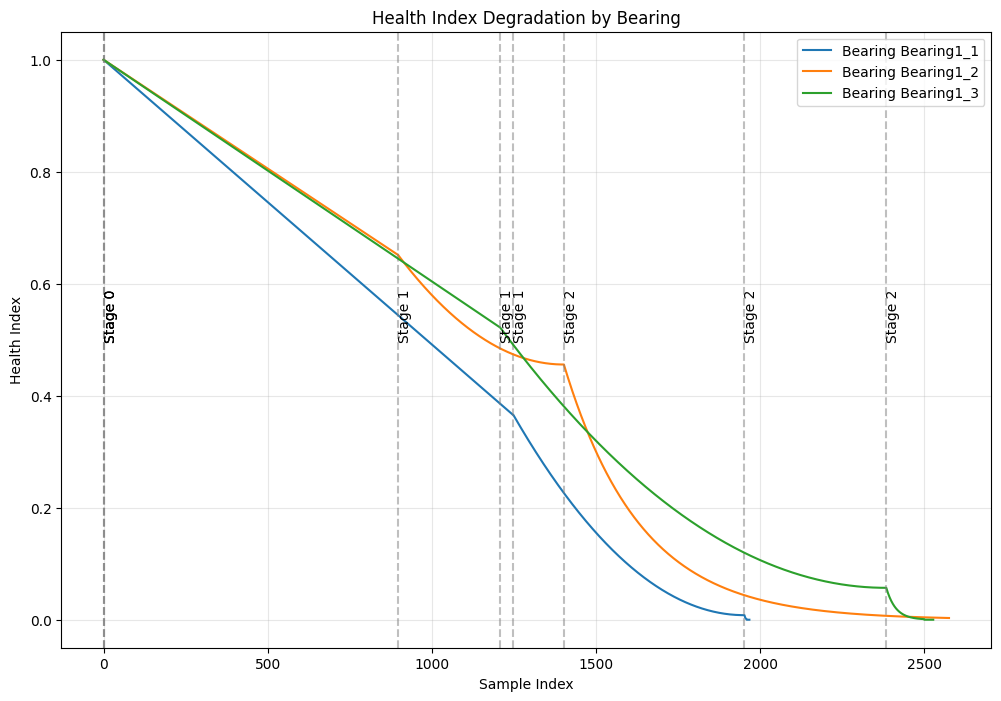

Health index added to datasets and saved!


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def add_health_index(dataset):
    """
    Add a health index column to the bearing dataset based on the stage information.

    The health index decreases at different rates for each stage:
    - Stage 0: Slow linear decrease
    - Stage 1: Faster quadratic decrease
    - Stage 2: Very fast exponential decrease

    Returns the dataset with an added 'health_index' column.
    """
    # Create a new column for health index
    dataset['rul'] = 0.0

    # Get unique bearings in the dataset
    bearings = dataset['bearing'].unique()

    # Process each bearing separately
    for bearing in bearings:
        # Get data for this specific bearing
        bearing_data = dataset[dataset['bearing'] == bearing].copy()

        # Sort by file_idx and window_start to ensure chronological order
        bearing_data = bearing_data.sort_values(by=['file_idx', 'window_start'])

        # Get the total number of samples for this bearing (lifetime)
        total_samples = len(bearing_data)

        # Find how many samples are in each stage
        stage_counts = bearing_data['stage'].value_counts()

        # Find indices where stages change
        stage_data = {}
        for stage in [0, 1, 2]:
            stage_rows = bearing_data[bearing_data['stage'] == stage]
            if not stage_rows.empty:
                stage_data[stage] = {
                    'start_idx': stage_rows.index.min(),
                    'end_idx': stage_rows.index.max(),
                    'count': len(stage_rows),
                    'proportion': len(stage_rows) / total_samples
                }

        # If we're missing any stages, skip this bearing
        if len(stage_data) < 1:
            print(f"Warning: Bearing {bearing} does not have any valid stages. Skipping.")
            continue

        # Calculate health transition points based on stage proportions
        # Start with health = 1.0
        # Calculate where each stage transition should occur in terms of health
        transition_points = {}

        # Start with full health
        current_health = 1.0

        # Determine how much health to decrease in each stage based on data proportions
        stage_decreases = {}
        total_proportion = sum(stage_data[stage]['proportion'] for stage in stage_data)

        # Calculate decreases proportionally to the number of samples in each stage
        for stage in stage_data:
            # Calculate decrease as proportion of total remaining health
            if total_proportion > 0:
                stage_decreases[stage] = stage_data[stage]['proportion'] / total_proportion
            else:
                # Fallback if proportions can't be calculated
                stage_decreases[stage] = 1 / len(stage_data)

        # Calculate transition points
        for stage in sorted(stage_data.keys()):
            start_health = current_health
            end_health = current_health - stage_decreases[stage]
            if end_health < 0:
                end_health = 0

            transition_points[stage] = {
                'start_health': start_health,
                'end_health': end_health
            }

            current_health = end_health

        # Calculate health index for each row in this bearing's data
        for idx in bearing_data.index:
            # Determine which stage this row belongs to
            stage = bearing_data.loc[idx, 'stage']

            if stage not in stage_data or stage not in transition_points:
                # Skip if stage data is missing
                continue

            # Get the start and end indices for this stage
            stage_start_idx = stage_data[stage]['start_idx']
            stage_end_idx = stage_data[stage]['end_idx']

            # Calculate relative position within this stage (0 to 1)
            if stage_end_idx == stage_start_idx:
                # Handle edge case where stage has only one sample
                stage_progress = 0
            else:
                # Calculate normalized progress through this stage
                row_position = bearing_data.index.get_loc(idx) - bearing_data.index.get_loc(stage_start_idx)
                stage_length = bearing_data.index.get_loc(stage_end_idx) - bearing_data.index.get_loc(stage_start_idx)
                stage_progress = row_position / stage_length

            # Get the health range for this stage
            start_health = transition_points[stage]['start_health']
            end_health = transition_points[stage]['end_health']

            # Calculate health index based on stage

            ## TODO: RUL-Distribution
            if stage == 0:
                # Stage 0: Linear decrease (slow)
                health_index = start_health - stage_progress * (start_health - end_health)

            elif stage == 1:
                # Stage 1: Quadratic decrease (faster)
                # Quadratic function to decrease health
                a = start_health
                b = end_health - start_health
                health_index = a + b * (2 * stage_progress - stage_progress ** 2)

            elif stage == 2:
                # Stage 2: Exponential decrease (very fast)
                # Exponential function to rapidly decrease health
                a = start_health
                b = 5  # Controls how steep the exponential decline is
                health_index = a * np.exp(-b * stage_progress)
                if health_index < 0.001:  # Set very small values to 0
                    health_index = 0

            else:
                health_index = 0.0  # Default for unknown stages

            # Update the health index in the original dataset
            dataset.loc[idx, 'rul'] = health_index

    return dataset

# Load your datasets
train_dataset = pd.read_csv("bearing_train_data_with_stages.csv")
test_dataset = pd.read_csv("bearing_test_data_with_stages.csv")


train_dataset = add_health_index(train_dataset)
test_dataset = add_health_index(test_dataset)

# Visualize health index for a few bearings to validate
def plot_health_index(dataset, bearing_ids):
    plt.figure(figsize=(12, 8))

    for bearing_id in bearing_ids:
        bearing_data = dataset[dataset['bearing'] == bearing_id].sort_index()

        # Plot health index
        plt.plot(range(len(bearing_data)), bearing_data['rul'],
                 label=f'Bearing {bearing_id}')

        # Mark stage transitions
        for stage in [0, 1, 2]:
            stage_start = bearing_data.index[bearing_data['stage'] == stage].min()
            if not pd.isna(stage_start):
                stage_pos = bearing_data.index.get_loc(stage_start)
                plt.axvline(x=stage_pos, color='gray', linestyle='--', alpha=0.5)
                plt.text(stage_pos, 0.5, f'Stage {stage}', rotation=90)

    plt.title('Health Index Degradation by Bearing')
    plt.xlabel('Sample Index')
    plt.ylabel('Health Index')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Try to plot for the first 3 bearings in the training dataset
bearings_to_plot = train_dataset['bearing'].unique()[:3]
plot_health_index(train_dataset, bearings_to_plot)

# Save the updated datasets
train_dataset.to_csv("bearing_train_data_with_health_index.csv", index=False)
test_dataset.to_csv("bearing_test_data_with_health_index.csv", index=False)

print("Health index added to datasets and saved!")

# Model Configuration Options

## Feature Engineering

### Additional Features to Incorporate
- **Condition indicators** (vibration, temperature, pressure)
- **Operational stages** (startup, normal, overload, shutdown)
- **Maintenance history** (time since last service)
- **Environmental factors** (ambient temperature, humidity)

```python
feature_set = {
    'primary': sensor_features,
    'condition': condition_indicators,
    'stage': operational_stage,
    'env': environmental_factors
}
```

## Window Size Options
Configure the number of time windows for sequence processing:

| Windows | Use Case                          | Sample Code                   |
|---------|-----------------------------------|-------------------------------|
| 1       | Single snapshot analysis          | `window_size = 1`             |
| 2       | Short-term trend analysis         | `window_size = 2`             |
| 10      | Medium-term pattern recognition   | `window_size = 10`            |
| 100     | Long-term sequence modeling       | `window_size = 100`           |

## Model Architectures

### Available Hybrid Models

| Model         | Description                          | Architecture Code              |
|---------------|--------------------------------------|--------------------------------|
| CNN-LSTM      | CNN feature extraction + LSTM temporal processing | `Sequential([Conv1D(), LSTM()])` |
| CNN-BiLSTM    | CNN + Bidirectional LSTM             | `Sequential([Conv1D(), Bidirectional(LSTM())])` |
| CNN-GRU       | CNN + Gated Recurrent Unit           | `Sequential([Conv1D(), GRU()])` |
| TCN           | Temporal Convolutional Network       | `TCN(return_sequences=True)`   |
| Transformer   | Self-attention based architecture    | `TransformerEncoder()`         |

### Implementation Template


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
import matplotlib.pyplot as plt

# Load datasets
train_dataset = pd.read_csv("bearing_train_data_with_health_index.csv")
test_dataset = pd.read_csv("bearing_test_data_with_health_index.csv")

def create_windows(df, window_size=5):
    """
    Create sliding windows for time series data, handling multiple bearings

    Args:
    df (pd.DataFrame): Input dataframe
    window_size (int): Size of the sliding window

    Returns:
    tuple: X (features), y (RUL)
    """
    # Group by bearing to ensure windows are created separately for each bearing
    windows_X, windows_y = [], []

    for bearing, bearing_group in df.groupby('bearing'):
        # Sort by window_start to ensure chronological order
        # Extract feature columns (exclude 'rul', 'condition', 'bearing', etc.)
        feature_columns = [col for col in df.columns if col not in
                           ['rul', 'condition', 'bearing', 'file_idx', 'window_start', 'stage', 'stage_desc']]

        # Create sliding windows
        for i in range(len(bearing_group) - window_size + 1):
            window = bearing_group.iloc[i:i+window_size]

            # Flatten the window features
            window_features = window[feature_columns].values.flatten()

            # Use the RUL of the last point in the window
            window_rul = window['rul'].iloc[-1]

            windows_X.append(window_features)
            windows_y.append(window_rul)

    return np.array(windows_X), np.array(windows_y)

# Prepare training and test data
##TODO: WINDOW_SIZE2
X_train, y_train = create_windows(train_dataset, window_size=5)
X_test, y_test = create_windows(test_dataset, window_size=5)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

# 1) Example: Split your already-scaled training data further into train and validation sets.
#    This ensures X_val_scaled and y_val are defined.
#    (Adjust test_size, random_state, etc. as needed for your case.)
X_train_scaled, X_val_scaled, y_train, y_val = train_test_split(
    X_train_scaled, y_train, test_size=0.2, random_state=42
)

# 2) Build the CNN-LSTM model.
def create_cnn_lstm_model(input_shape):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Reshape((input_shape, 1), input_shape=(input_shape,)))
    model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation='relu'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(tf.keras.layers.LSTM(32, return_sequences=False))
    model.add(tf.keras.layers.Dense(16, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='softplus'))
    model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                  loss='mean_squared_error',
                  metrics=['mae'])
    return model

# 3) Build the Transformer model.
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(ff_dim, activation='relu'),
            tf.keras.layers.Dense(embed_dim)
        ])
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

def create_transformer_model(input_shape):
    inputs = tf.keras.Input(shape=(input_shape,))
    x = tf.keras.layers.Reshape((1, input_shape))(inputs)
    x = tf.keras.layers.Dense(32)(x)
    x = TransformerBlock(embed_dim=32, num_heads=2, ff_dim=64)(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dense(16, activation='relu')(x)
    outputs = tf.keras.layers.Dense(1, activation='softplus')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                  loss='mean_squared_error',
                  metrics=['mae'])
    return model

# 4) Utility to print metrics
def print_metrics(y_true, y_pred, dataset_name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{dataset_name} Metrics:")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"R-squared Score: {r2:.4f}\n")

# 5) Visualization by bearing
def visualize_bearing_predictions(test_dataset, test_pred):
    windows_with_bearing = []
    windows_true_rul = []

    # Adjust these if your dataset column names differ
    for bearing, bearing_group in test_dataset.groupby('bearing'):
        for i in range(len(bearing_group) - 4):
            window = bearing_group.iloc[i:i+5]
            windows_with_bearing.append(bearing)
            windows_true_rul.append(window['health_index'].iloc[-1])

    windows_with_bearing = np.array(windows_with_bearing)
    windows_true_rul = np.array(windows_true_rul)

    plt.figure(figsize=(15,10))
    for b in np.unique(windows_with_bearing):
        mask = (windows_with_bearing == b)
        plt.scatter(windows_true_rul[mask], test_pred[mask], label=f'Bearing {b}', alpha=0.7)

    plt.plot([0, np.max(windows_true_rul)], [0, np.max(windows_true_rul)],
             color='red', linestyle='--', label='Perfect Prediction')
    plt.xlabel('True RUL')
    plt.ylabel('Predicted RUL')
    plt.title('RUL Prediction by Bearing')
    plt.legend()
    plt.tight_layout()
    plt.savefig('rul_prediction_by_bearing.png')
    plt.close()

# 6) Function to find best alpha via grid search on validation set
def find_best_weight(y_true, pred1, pred2, step=0.01):
    best_alpha = 0.0
    best_mse = float('inf')
    for alpha in np.arange(0, 1 + step, step):
        combined_pred = alpha * pred1 + (1 - alpha) * pred2
        mse = mean_squared_error(y_true, combined_pred)
        if mse < best_mse:
            best_alpha = alpha
            best_mse = mse
    return best_alpha

# 7) Create and train the CNN-LSTM model
model_cnn_lstm = create_cnn_lstm_model(X_train_scaled.shape[1])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_cnn_lstm.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# 8) Create and train the Transformer model
model_transformer = create_transformer_model(X_train_scaled.shape[1])
model_transformer.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# 9) Generate predictions for train, validation, and test sets
train_pred_cnn_lstm = model_cnn_lstm.predict(X_train_scaled).flatten()
val_pred_cnn_lstm   = model_cnn_lstm.predict(X_val_scaled).flatten()
test_pred_cnn_lstm  = model_cnn_lstm.predict(X_test_scaled).flatten()

train_pred_transformer = model_transformer.predict(X_train_scaled).flatten()
val_pred_transformer   = model_transformer.predict(X_val_scaled).flatten()
test_pred_transformer  = model_transformer.predict(X_test_scaled).flatten()

# 10) Determine best alpha on validation set
best_alpha = find_best_weight(y_val, val_pred_cnn_lstm, val_pred_transformer)

# 11) Ensemble predictions using best_alpha
train_ensemble = best_alpha * train_pred_cnn_lstm + (1 - best_alpha) * train_pred_transformer
test_ensemble  = best_alpha * test_pred_cnn_lstm  + (1 - best_alpha) * test_pred_transformer

# 12) Evaluate all models
print_metrics(y_train, train_pred_cnn_lstm,      "CNN-LSTM Training")
print_metrics(y_val,   val_pred_cnn_lstm,        "CNN-LSTM Validation")
print_metrics(y_test,  test_pred_cnn_lstm,       "CNN-LSTM Test")

print_metrics(y_train, train_pred_transformer,   "Transformer Training")
print_metrics(y_val,   val_pred_transformer,     "Transformer Validation")
print_metrics(y_test,  test_pred_transformer,    "Transformer Test")

print_metrics(y_train, train_ensemble,           "Ensemble Training")
print_metrics(y_val,   best_alpha * val_pred_cnn_lstm + (1 - best_alpha) * val_pred_transformer,
              "Ensemble Validation")
print_metrics(y_test,  test_ensemble,            "Ensemble Test")

# 13) Visualize on test data
visualize_bearing_predictions(test_dataset, test_ensemble)

# 14) Save final predictions
predictions_df = pd.DataFrame({
    'True_RUL': y_test,
    'Predicted_RUL': test_ensemble,
    'Absolute_Error': np.abs(y_test - test_ensemble)
})
predictions_df.to_csv('rul_predictions.csv', index=False)
print("Predictions saved to 'rul_predictions.csv'")


Epoch 1/100
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - loss: 0.0310 - mae: 0.1304 - val_loss: 0.0083 - val_mae: 0.0650
Epoch 2/100
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - loss: 0.0066 - mae: 0.0586 - val_loss: 0.0030 - val_mae: 0.0404
Epoch 3/100
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - loss: 0.0024 - mae: 0.0358 - val_loss: 0.0016 - val_mae: 0.0288
Epoch 4/100
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.0013 - mae: 0.0267 - val_loss: 0.0013 - val_mae: 0.0258
Epoch 5/100
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 9.8125e-04 - mae: 0.0230 - val_loss: 7.8302e-04 - val_mae: 0.0209
Epoch 6/100
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - loss: 7.2595e-04 - mae: 0.0199 - val_loss: 6.5238e-04 - val_mae: 0.0187
Epoch 7/100
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - loss: 6.5286e-04 - mae: 0.0186 - val_loss: 4.3418e-04 - val_mae: 0.0149
Epoch 8/100
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - loss: 5.3357e-04 - mae: 0.0169 - val_loss: 7.1599e-04 - val_ma

In [28]:
# 12) Evaluate all models
#print_metrics(y_train, train_pred_cnn_lstm,      "CNN-LSTM Training")
#print_metrics(y_val,   val_pred_cnn_lstm,        "CNN-LSTM Validation")
print_metrics(y_test,  test_pred_cnn_lstm,       "CNN-LSTM Test")

#print_metrics(y_train, train_pred_transformer,   "Transformer Training")
#print_metrics(y_val,   val_pred_transformer,     "Transformer Validation")
print_metrics(y_test,  test_pred_transformer,    "Transformer Test")

#print_metrics(y_train, train_ensemble,           "Ensemble Training")
#print_metrics(y_val,   best_alpha * val_pred_cnn_lstm + (1 - best_alpha) * val_pred_transformer,
#              "Ensemble Validation")
print_metrics(y_test,  test_ensemble,            "Ensemble Test")

CNN-LSTM Test Metrics:
Mean Squared Error: 0.0057
Mean Absolute Error: 0.0423
R-squared Score: 0.9409

Transformer Test Metrics:
Mean Squared Error: 0.0038
Mean Absolute Error: 0.0392
R-squared Score: 0.9606

Ensemble Test Metrics:
Mean Squared Error: 0.0037
Mean Absolute Error: 0.0392
R-squared Score: 0.9617



In [26]:
from sklearn.linear_model import LinearRegression

def combine_models_using_weighted_average(pred1, pred2, y_true):
    # Use linear regression to find the optimal weight for the two models' predictions
    model = LinearRegression()
    combined_preds = np.column_stack([pred1, pred2])
    model.fit(combined_preds, y_true)  # Fit using the validation set
    weights = model.coef_
    bias = model.intercept_

    # Combine predictions using learned weights
    combined_preds = np.dot(combined_preds, weights) + bias
    return combined_preds

# Get predictions from both models on the validation set
val_pred_cnn_lstm = model_cnn_lstm.predict(X_val_scaled).flatten()
val_pred_transformer = model_transformer.predict(X_val_scaled).flatten()

# Combine the predictions using the weighted average
val_ensemble = combine_models_using_weighted_average(val_pred_cnn_lstm, val_pred_transformer, y_val)

# Get predictions from both models on the test set
test_pred_cnn_lstm = model_cnn_lstm.predict(X_test_scaled).flatten()
test_pred_transformer = model_transformer.predict(X_test_scaled).flatten()
# Combine the predictions for the test set
test_ensemble = combine_models_using_weighted_average(test_pred_cnn_lstm, test_pred_transformer, y_test)

# Evaluate the models
print_metrics(y_train, train_pred_cnn_lstm, "CNN-LSTM Training")
print_metrics(y_val, val_pred_cnn_lstm, "CNN-LSTM Validation")
print_metrics(y_test, test_pred_cnn_lstm, "CNN-LSTM Test")

print_metrics(y_train, train_pred_transformer, "Transformer Training")
print_metrics(y_val, val_pred_transformer, "Transformer Validation")
print_metrics(y_test, test_pred_transformer, "Transformer Test")

#print_metrics(y_train, val_ensemble, "Ensemble Validation")
print_metrics(y_test, test_ensemble, "Ensemble Test")

# Visualize bearing predictions
visualize_bearing_predictions(test_dataset, test_ensemble)

# Save predictions to a CSV file
predictions_df = pd.DataFrame({
    'True_RUL': y_test,
    'Predicted_RUL': test_ensemble,
    'Absolute_Error': np.abs(y_test - test_ensemble)
})
predictions_df.to_csv('rul_predictions.csv', index=False)
print("Predictions saved to 'rul_predictions.csv'")

563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 946us/step
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 1s 935us/step
CNN-LSTM Training Metrics:
Mean Squared Error: 0.0000
Mean Absolute Error: 0.0030
R-squared Score: 0.9998

CNN-LSTM Validation Metrics:
Mean Squared Error: 0.0000
Mean Absolute Error: 0.0032
R-squared Score: 0.9998

CNN-LSTM Test Metrics:
Mean Squared Error: 0.0057
Mean Absolute Error: 0.0423
R-squared Score: 0.9409

Transformer Training Metrics:
Mean Squared Error: 0.0000
Mean Absolute Error: 0.0025
R-squared Score: 0.9999

Transformer Validation Metrics:
Mean Squared Error: 0.0000
Mean Absolute Error: 0.0025
R-squared Score: 0.9999

Transformer Test Metrics:
Mean Squared Error: 0.0038
Mean Absolute Error: 0.0392
R-squared Score: 0.9606

Ensemble Test Metrics:
Mean Squared Error: 0.0037
Mean Absolute Error: 0.0392
R-squared Score: 0.9617

Predictions saved to 'rul_predictions.csv'


In [7]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_bearing_predictions_over_time(dataset, predictions):
    windows_with_bearing = []
    windows_true_rul = []

    for bearing, bearing_group in dataset.groupby('bearing'):
        for i in range(len(bearing_group) - 4):
            window = bearing_group.iloc[i:i+5]
            windows_with_bearing.append(bearing)
            windows_true_rul.append(window['rul'].iloc[-1])

    windows_with_bearing = np.array(windows_with_bearing)
    windows_true_rul = np.array(windows_true_rul)
    predictions = np.array(predictions)

    min_len = min(len(windows_with_bearing), len(predictions))
    windows_with_bearing = windows_with_bearing[:min_len]
    windows_true_rul = windows_true_rul[:min_len]
    predictions = predictions[:min_len]

    unique_bearings = np.unique(windows_with_bearing)
    for bearing in unique_bearings:
        plt.figure(figsize=(10, 6))
        bearing_mask = (windows_with_bearing == bearing)
        true_rul = windows_true_rul[bearing_mask]
        pred_rul = predictions[bearing_mask]
        x_axis = np.linspace(0, 1, len(true_rul))
        plt.plot(x_axis, true_rul, label='True RUL')
        plt.plot(x_axis, pred_rul, label='Predicted RUL')
        plt.fill_between(x_axis, true_rul, pred_rul, alpha=0.2)
        plt.xlabel('Normalized Time (0=start, 1=end of life)')
        plt.ylabel('RUL')
        plt.title(f'RUL Prediction Over Time - Bearing {bearing}')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f'rul_over_time_bearing_{bearing}.png')
        plt.show()


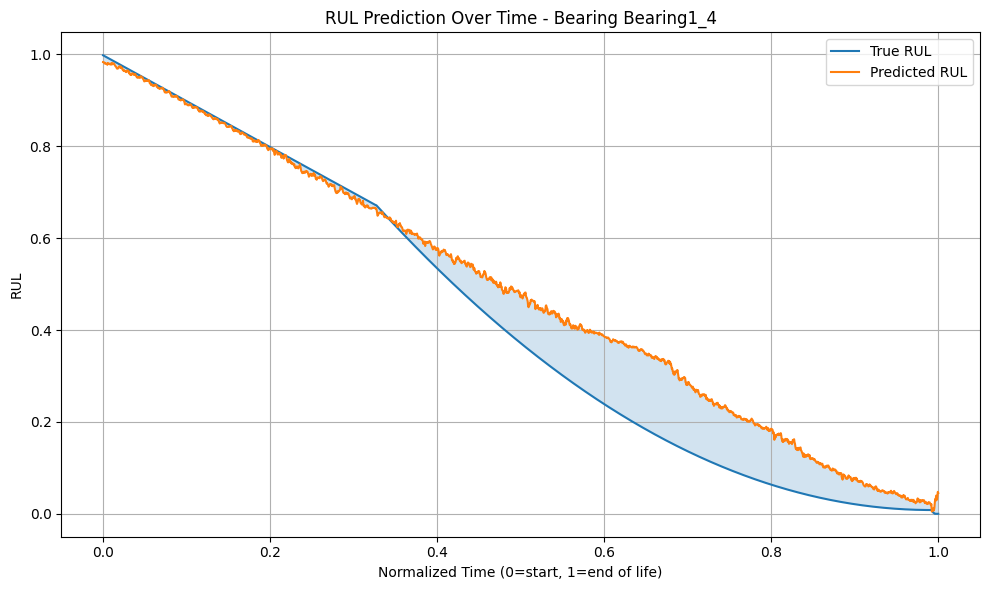

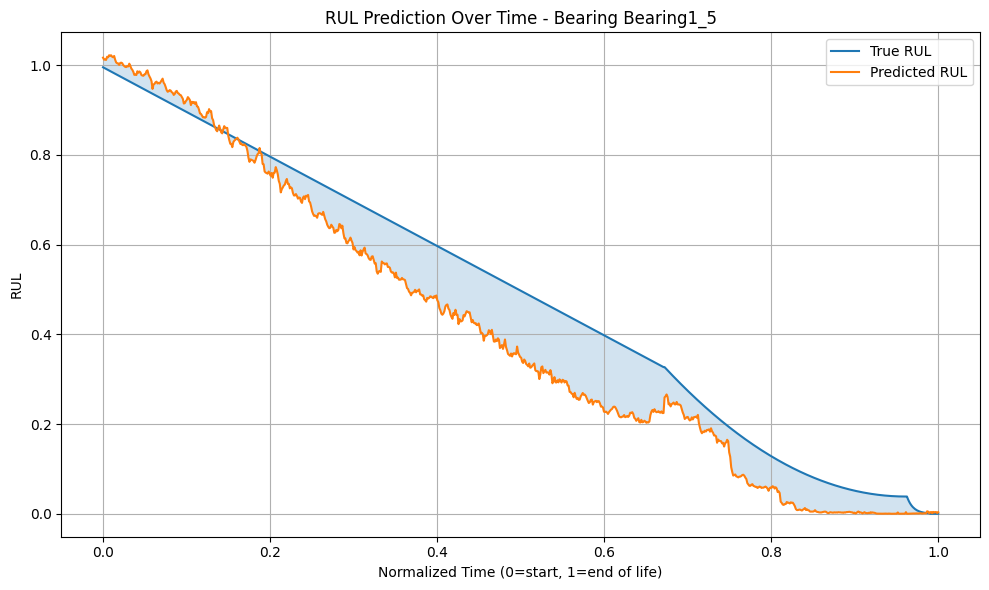

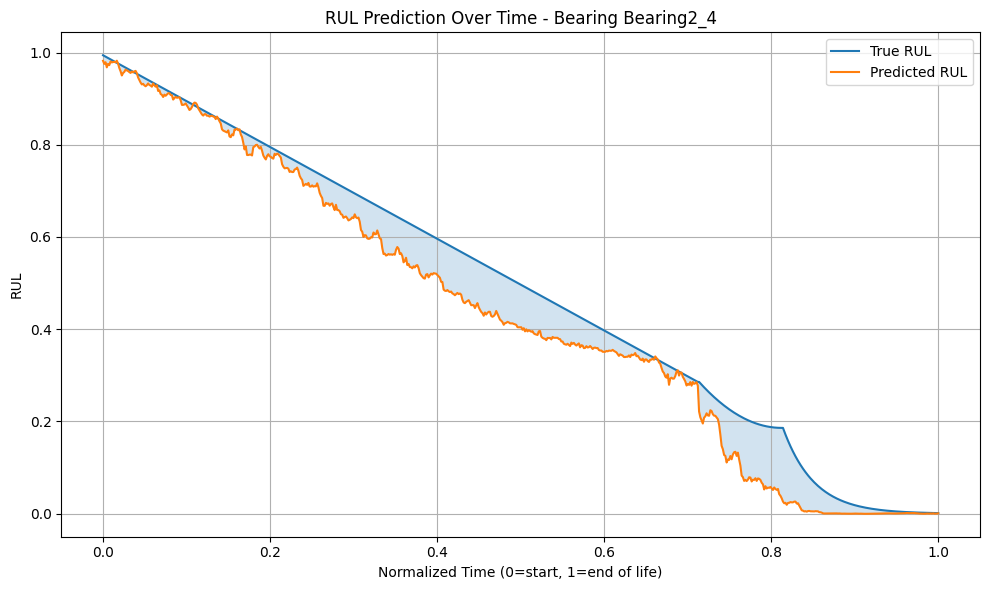

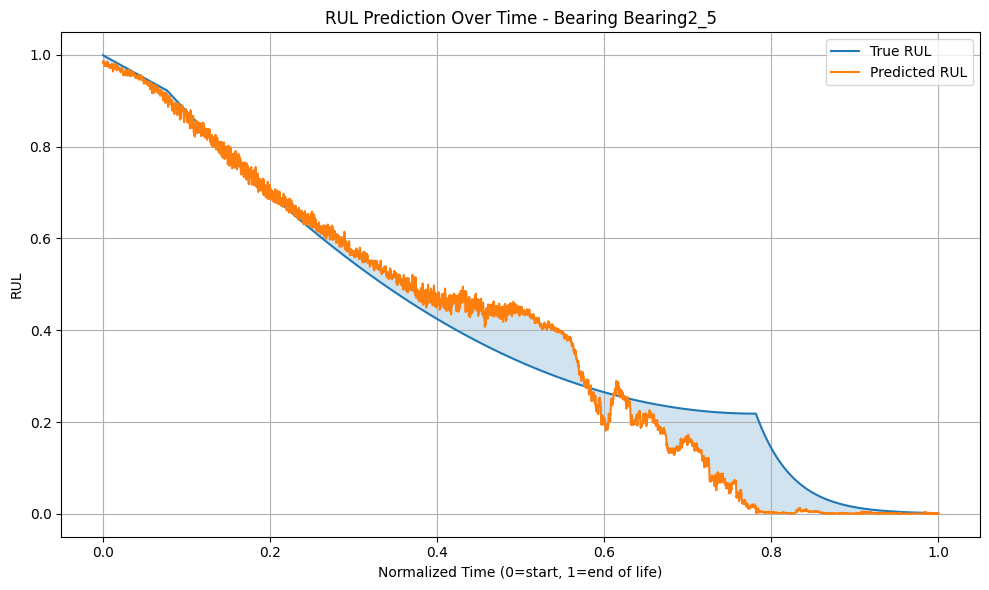

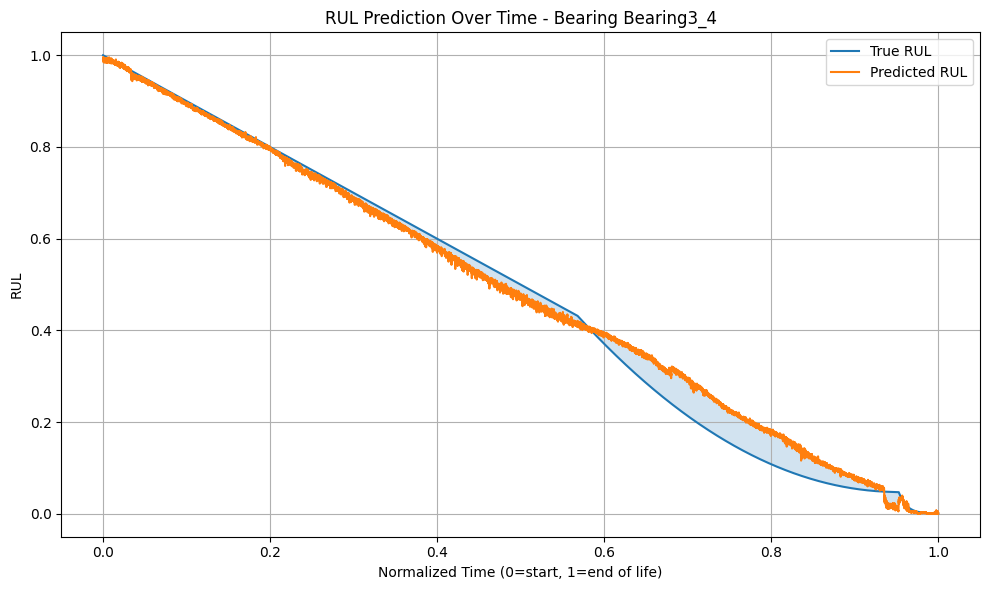

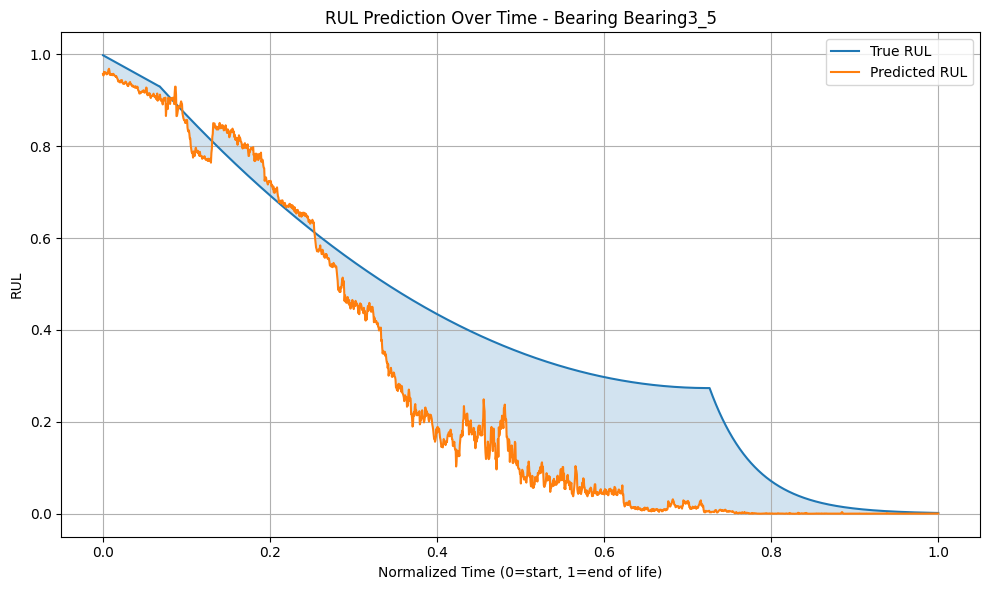

In [24]:
#visualize_bearing_predictions_over_time(train_dataset, train_ensemble)
visualize_bearing_predictions_over_time(test_dataset, test_ensemble)

In [28]:
import numpy as np
import matplotlib.pyplot as plt

def plot_test_predictions_separately(test_dataset, test_pred):
    """
    Plots test predictions separately for each bearing.
    Assumes test_dataset contains a 'bearing' column and a 'health_index' column,
    and test_pred is aligned so that each row in the dataset corresponds to the
    correct entry in test_pred.

    If you're using windowed data (sliding windows), ensure test_pred is in the
    same order the windows are generated.
    """

    # Recreate the windowed test dataset with bearing information
    windows_with_bearing = []
    windows_true_rul = []

    for bearing, bearing_group in test_dataset.groupby('bearing'):
        for i in range(len(bearing_group) - 4):
            window = bearing_group.iloc[i:i+5]
            windows_with_bearing.append(bearing)
            windows_true_rul.append(window['health_index'].iloc[-1])

    windows_with_bearing = np.array(windows_with_bearing)
    windows_true_rul = np.array(windows_true_rul)

    # Plot predictions for each bearing separately
    unique_bearings = np.unique(windows_with_bearing)
    for b in unique_bearings:
        mask = (windows_with_bearing == b)
        true_rul_bearing = windows_true_rul[mask]
        pred_rul_bearing = test_pred[mask]

        plt.figure()
        plt.scatter(true_rul_bearing, pred_rul_bearing, alpha=0.7)
        plt.plot([0, np.max(true_rul_bearing)], [0, np.max(true_rul_bearing)],
                 color='red', linestyle='--', label='Perfect Prediction')
        plt.xlabel('True RUL')
        plt.ylabel('Predicted RUL')
        plt.title(f'RUL Prediction for Bearing {b}')
        plt.legend()
        plt.tight_layout()
        plt.savefig(f'bearing_{b}_prediction.png')
        plt.close()


In [29]:
plot_test_predictions_separately(test_dataset, test_ensemble)

In [43]:
import numpy as np
import matplotlib.pyplot as plt

def plot_test_predictions_inverted(test_dataset, test_pred):
    """
    Plots test predictions separately for each bearing, with the RUL axis
    going from 1 down to 0 (both true and predicted). This means the top-left
    of the plot is RUL=1 and the bottom-right is RUL=0.

    Assumes:
      - test_dataset has columns ['bearing', 'health_index'] (health_index in [0..1])
      - test_pred is aligned with how you iterated over test_dataset (especially if windowing)
    """

    # Collect bearing and final RUL from each 5-step window (or however your window size is set).
    windows_with_bearing = []
    windows_true_rul = []
    for bearing, bearing_group in test_dataset.groupby('bearing'):
        for i in range(len(bearing_group) - 4):
            window = bearing_group.iloc[i:i+5]
            windows_with_bearing.append(bearing)
            windows_true_rul.append(window['health_index'].iloc[-1])

    windows_with_bearing = np.array(windows_with_bearing)
    windows_true_rul = np.array(windows_true_rul)

    unique_bearings = np.unique(windows_with_bearing)

    for b in unique_bearings:
        mask = (windows_with_bearing == b)
        true_rul_bearing = windows_true_rul[mask]
        pred_rul_bearing = test_pred[mask]

        plt.figure()
        plt.scatter(true_rul_bearing, pred_rul_bearing, alpha=0.7, label='Predictions')

        # Plot a diagonal line from (1,1) to (0,0)
        plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Perfect Prediction')

        # Force the axes to go from 1 (top-left) down to 0 (bottom-right)
        plt.xlim(0, 1)
        plt.ylim(1, 0)

        plt.xlabel('True RUL (1 → 0)')
        plt.ylabel('Predicted RUL (1 → 0)')
        plt.title(f'Bearing {b}: RUL Predictions (Inverted Axes)')
        plt.legend()
        plt.tight_layout()

        # Show the plot; do not save
        plt.show()


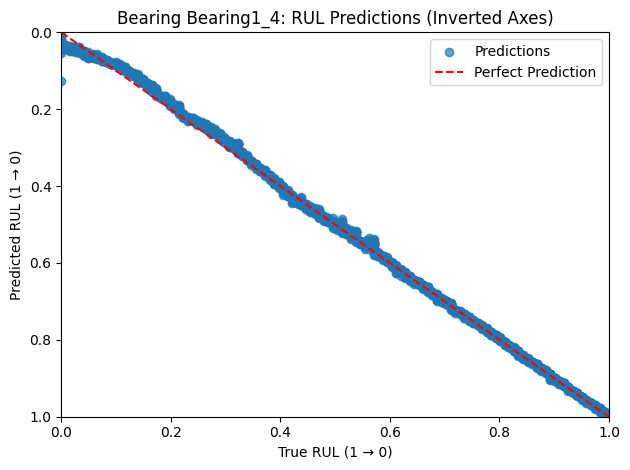

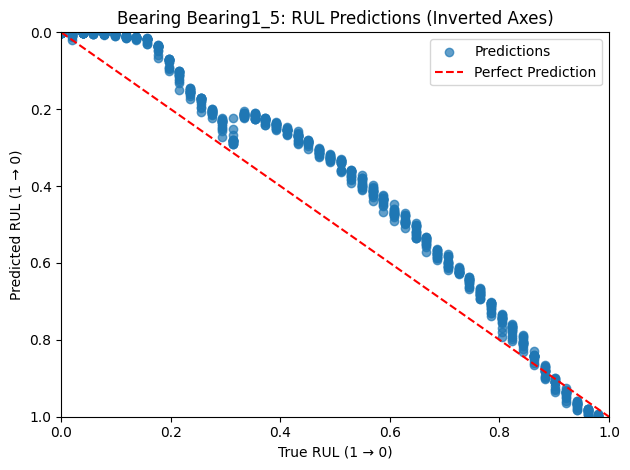

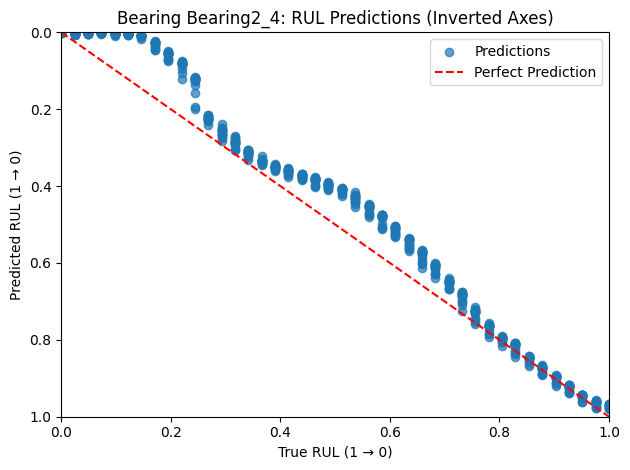

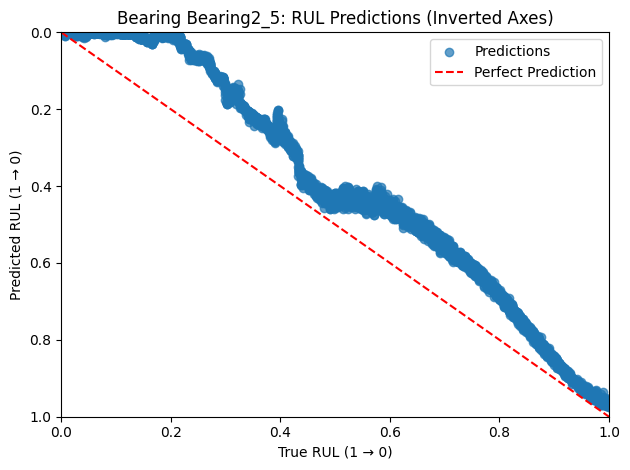

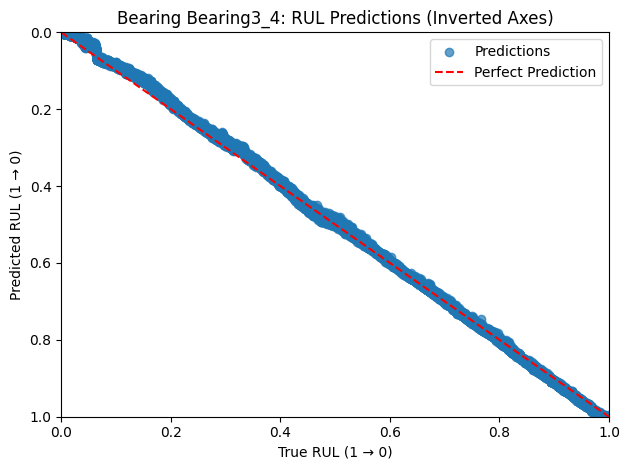

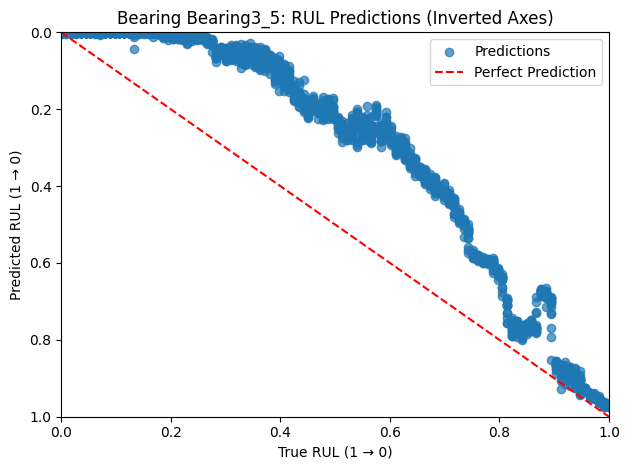

In [44]:
plot_test_predictions_inverted(test_dataset, test_ensemble)


# Models



In [ ]:


#TODO: MODELS
# Build the model

import tensorflow as tf

def custom_loss(y_true, y_pred):
    error = y_pred - y_true
    squared_error = tf.square(error)

    # Penalize errors > 0.05
    threshold = 0.1
    heavy_penalty = tf.where(tf.abs(error) > threshold,
                             squared_error * 2,  # Increase penalty
                             squared_error)

    # Penalize overprediction (when prediction > true)
    over_pred_penalty = tf.where(error > 0,
                                 error * 1.1,  # Weight overpredictions
                                 0.0)

    total_loss = heavy_penalty + over_pred_penalty
    return tf.reduce_mean(total_loss)



def create_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_shape,)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1, activation='softplus')  # Output layer
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='mean_squared_error',  # Use your new loss here
                  metrics=['mae'])
    return model

# Create and train the model
model = create_model(X_train_scaled.shape[1])
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model
train_pred = model.predict(X_train_scaled).flatten()
test_pred = model.predict(X_test_scaled).flatten()

# Metrics for overall performance
def print_metrics(y_true, y_pred, dataset_name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"{dataset_name} Metrics:")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"R-squared Score: {r2:.4f}\n")

print_metrics(y_train, train_pred, "Training")
print_metrics(y_test, test_pred, "Test")

# Visualization of predictions per bearing
def visualize_bearing_predictions(test_dataset, test_pred):
    # Recreate the windowed test dataset with bearing information
    windows_with_bearing = []
    windows_true_rul = []

    for bearing, bearing_group in test_dataset.groupby('bearing'):

        feature_columns = [col for col in test_dataset.columns if col not in
                           ['rul', 'condition', 'bearing', 'file_idx', 'window_start', 'stage', 'stage_desc']]

        for i in range(len(bearing_group) - 4):
            window = bearing_group.iloc[i:i+5]
            windows_with_bearing.append(bearing)
            windows_true_rul.append(window['rul'].iloc[-1])

    # Convert to numpy arrays for easier manipulation
    windows_with_bearing = np.array(windows_with_bearing)
    windows_true_rul = np.array(windows_true_rul)

    # Plot predictions for each bearing
    plt.figure(figsize=(15, 10))
    unique_bearings = np.unique(windows_with_bearing)

    for bearing in unique_bearings:
        bearing_mask = windows_with_bearing == bearing
        true_rul = windows_true_rul[bearing_mask]
        pred_rul = test_pred[bearing_mask]

        plt.scatter(true_rul, pred_rul, label=f'Bearing {bearing}', alpha=0.7)

    plt.plot([0, np.max(windows_true_rul)], [0, np.max(windows_true_rul)],
             color='red', linestyle='--', label='Perfect Prediction')

    plt.xlabel('True RUL')
    plt.ylabel('Predicted RUL')
    plt.title('RUL Prediction by Bearing')
    plt.legend()
    plt.tight_layout()
    plt.savefig('rul_prediction_by_bearing.png')
    plt.close()

# Generate bearing-specific predictions visualization
visualize_bearing_predictions(test_dataset, test_pred)

# Save predictions to CSV for detailed analysis
predictions_df = pd.DataFrame({
    'True_RUL': y_test,
    'Predicted_RUL': test_pred,
    'Absolute_Error': np.abs(y_test - test_pred)
})
predictions_df.to_csv('rul_predictions.csv', index=False)

print("Predictions saved to 'rul_predictions.csv'")
print("Bearing-specific prediction plot saved to 'rul_prediction_by_bearing.png'")

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_bearing_predictions_over_time(test_dataset, test_pred):
    windows_with_bearing = []
    windows_true_rul = []

    # Generate rolling windows and track bearing info + true RULs
    for bearing, bearing_group in test_dataset.groupby('bearing'):
        for i in range(len(bearing_group) - 4):
            window = bearing_group.iloc[i:i+5]
            windows_with_bearing.append(bearing)
            windows_true_rul.append(window['rul'].iloc[-1])

    windows_with_bearing = np.array(windows_with_bearing)
    windows_true_rul = np.array(windows_true_rul)
    test_pred = np.array(test_pred)

    unique_bearings = np.unique(windows_with_bearing)

    for bearing in unique_bearings:
        plt.figure(figsize=(10, 6))

        bearing_mask = windows_with_bearing == bearing
        true_rul = windows_true_rul[bearing_mask]
        pred_rul = test_pred[bearing_mask]

        x_axis = np.linspace(0, 1, len(true_rul))  # normalized lifetime

        plt.plot(x_axis, true_rul, label='True RUL', color='blue')
        plt.plot(x_axis, pred_rul, label='Predicted RUL', color='orange')
        plt.fill_between(x_axis, true_rul, pred_rul, color='gray', alpha=0.2)

        plt.xlabel('Normalized Time (0=start, 1=end of life)')
        plt.ylabel('RUL')
        plt.title(f'RUL Prediction Over Time - Bearing {bearing}')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

        # Save and show
        plt.savefig(f'rul_over_time_bearing_{bearing}.png')
        plt.show()  # Show the plot
visualize_bearing_predictions_over_time(train_dataset, train_pred)
visualize_bearing_predictions_over_time(test_dataset, test_pred)

NameError: name 'train_pred' is not defined